# **We import FLOWPM**

In [1]:
#library flowpm
!pip install --quiet  git+https://github.com/modichirag/flowpm.git@blogpost;
!git clone --quiet -b blogpost https://github.com/modichirag/flowpm.git;

fatal: destination path 'flowpm' already exists and is not an empty directory.


In [4]:
import tensorflow as tf
import numpy as np
import flowpm
from scipy.interpolate import InterpolatedUnivariateSpline as iuspline
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

from flowpm import linear_field, lpt_init, nbody, cic_paint
 
#cosmo = flowpm.cosmology.Planck15()

# **We import the libraries**

In [2]:
#Setup
%tensorflow_version 1.x
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import InterpolatedUnivariateSpline as iuspline
%matplotlib inline
#
#import tensorflow as tf
#
from flowpm import linear_field, lpt_init, nbody, cic_paint
import flowpm

TensorFlow 1.x selected.


# **Universe evolved from $a_0=0.1$ to $a=1.0$**

In [6]:
## Define key parameters of our Universe
a0      = 0.1       #the initial epoch from where we begin the evolution, a0=0 corresponds to birth but is numerically unstable
af      = 1.0       #final epoch where we visualize structures, af=1 corresponds to today
n_steps = 30        #number of time-steps to split the total evolution into
L       = 100       #Physical size of the Universe in Mpc/h
N       = 64        #Number of mesh-points along one axis, size of the cube. Then the number of particles will be N^3
batch   = 2         #Batch size, how many independent Universes to simulate

stages = np.linspace(a0, af, n_steps, endpoint=True) #time-steps for the integration

#Read-in the linear power-spectrum from a file. 
#This is determined by some fundamental parameters of our Universe that cosmologists are interested in
#In N-body simulations, this determines the clustering of the Universe at the initial epoch a0
klin = np.loadtxt('flowpm/flowpm/data/Planck15_a1p00.txt').T[0]
plin = np.loadtxt('flowpm/flowpm/data/Planck15_a1p00.txt').T[1]
ipklin = iuspline(klin, plin)

#tf.reset_default_graph()
# Generate Gaussian initial conditions for matter density 
initial_conditions = flowpm.linear_field(N,  L, ipklin, batch_size=batch)   

# Sample particles, i.e. generate the initial displacement and velocity
# State is a tensor of shape (3, batch, N^3, 3)
# where the last axiss corresponds to the 3: x, y, z directions 
# and the first axis corresponds to position, velocity, acceleration of particle
state = flowpm.lpt_init(initial_conditions, a0=a0)   

# Evolve particles from initial state down to a=af
final_state = flowpm.nbody(state, stages, N)         

# Retrieve final density field i.e interpolate the particles to the mesh
final_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), final_state[0])

#Execute the graph!
#with tf.Session() as sess:
ic, istate, fstate, sim = ([initial_conditions, state, final_state, final_field])

In [7]:
#Execute the graph!
with tf.Session() as sess:
    ic, istate, fstate, sim = sess.run([initial_conditions, state, final_state, final_field])

No handles with labels found to put in legend.


[]

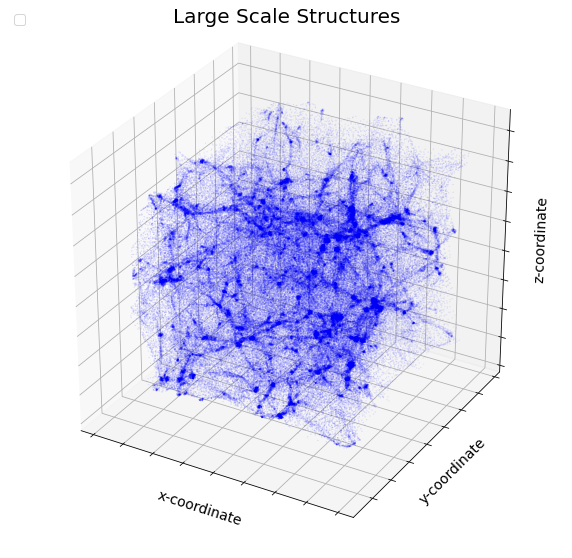

In [8]:
#Create figure
fig=plt.figure(figsize=(10,10))#Create 3D axes
try: ax=fig.add_subplot(111,projection="3d")
except : ax=Axes3D(fig) 
ax.scatter(fstate[0, 0,:,0],fstate[0, 0,:,1], fstate[0, 0,:,2],color="blue",marker=".",s=.02)
ax.set_xlabel("x-coordinate",fontsize=14)
ax.set_ylabel("y-coordinate",fontsize=14)
ax.set_zlabel("z-coordinate",fontsize=14)
ax.set_title("Large Scale Structures\n",fontsize=20)
ax.legend(loc="upper left",fontsize=14)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
#plt.savefig('3dfinal.png', dpi=1200)

In [9]:
#density function
def density(n):
    #final density
    xf=fstate[0, 0,:,0]
    yf=fstate[0, 0,:,1]
    zf= fstate[0, 0,:,2]
    #cubes N=100
    N=n
    deltaf=np.zeros((N,N,N))
    xmax=max(xf)
    xmin=min(xf)
    ymax=max(yf)
    ymin=min(yf)
    zmax=max(zf)
    zmin=min(zf)
    for ii in range(len(xf)):
        i=int(N*((xf[ii]-xmin)/(xmax-xmin)))
        j=int(N*((yf[ii]-ymin)/(ymax-ymin)))
        k=int(N*((zf[ii]-zmin)/(zmax-zmin)))
        deltaf[i-1,j-1,k-1]+=1
    return deltaf

In [10]:
d1=density(100);

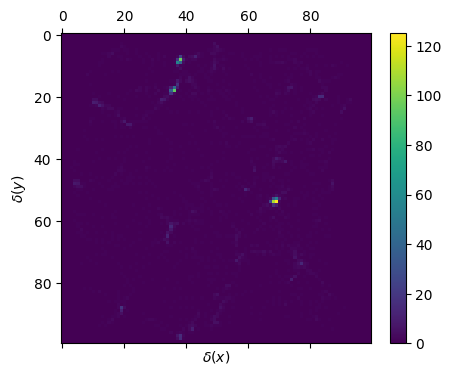

In [11]:
fig = plt.figure(figsize=(5,4), dpi=100)
plt.matshow(d1[49,:,:],fignum=1,cmap=plt.cm.viridis, aspect='auto')
plt.colorbar()
plt.xlabel(r'$\delta(x)$', fontsize=10)
plt.ylabel(r'$\delta(y)$', fontsize=10)
plt.show()

In [12]:
def PS(d):
    FS=np.fft.fftshift(np.fft.fftn(d))
    #return FS

    #parte real
    #fig = plt.figure(figsize=(7,6),dpi=100)
    #plt.matshow(PS(d)[49,:,:].real,fignum=1,cmap=plt.cm.viridis, aspect='auto')
    #plt.colorbar()
    #plt.xlabel(r'$fft(\delta(x))$', fontsize=10)
    #plt.ylabel(r'$fft(\delta(y))$', fontsize=10)
    #plt.show()

    #parte imaginaria
    #fig = plt.figure(figsize=(7,6), dpi=100)
    #plt.matshow(PS(d)[49,:,:].imag,fignum=1,cmap=plt.cm.viridis, aspect='auto')
    #plt.colorbar()
    #plt.xlabel(r'$fft(\delta(x))$', fontsize=10)
    #plt.ylabel(r'$fft(\delta(y))$', fontsize=10)
    #plt.show()

    kx=np.fft.fftshift(np.fft.fftfreq(len(FS[0:100,0,0])))
    ky=np.fft.fftshift(np.fft.fftfreq(len(FS[0,0:100,0])))
    kz=np.fft.fftshift(np.fft.fftfreq(len(FS[0,0,0:100])))
    kxmax=max(kx)
    kxmin=min(kz)
    kymax=max(ky)
    kymin=min(ky)
    kzmax=max(kz)
    kzmin=min(kz)

    #Estimación del espectro de Potencias
    Nbins=50
    dk=(kxmax-kxmin)/Nbins
    sumk=np.zeros(Nbins)
    count=np.zeros(Nbins)
    modk=np.zeros(Nbins)
    kp=np.arange(0,Nbins)*dk


    kx=np.fft.fftshift(np.fft.fftfreq(len(FS[0:100,0,0])))
    ky=np.fft.fftshift(np.fft.fftfreq(len(FS[0,0:100,0])))
    kz=np.fft.fftshift(np.fft.fftfreq(len(FS[0,0,0:100])))

    for ii in range(len(kx)):
        for jj in range(len(ky)):
            for kk in range(len(kz)):
                modk=np.sqrt(kx[ii]**2+ky[jj]**2+kz[kk]**2)
                ind= int(np.floor((modk)/dk))
                sumk[ind]+=np.abs(FS[ii,jj,kk])**2 #al cuadrado
                count[ind]+=1
    P=(sumk/count)*(1/(2*np.pi)**3)
    #P.shape  
    return P, kp

In [13]:
psd1, kpd1=PS(d1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


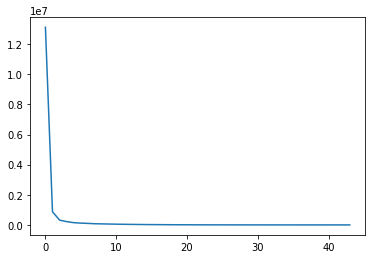

In [14]:
plt.plot(psd1)

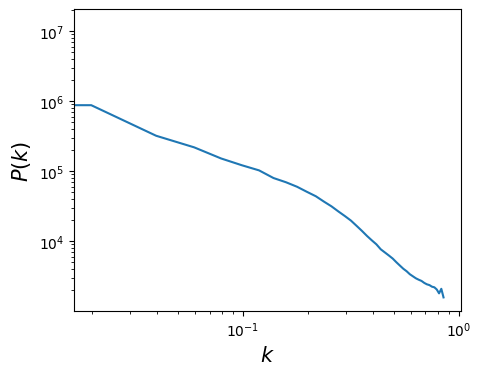

In [15]:
fig = plt.figure(figsize=(5,4), dpi=100)
plt.loglog(kpd1,psd1)

plt.xlabel(r'$k$', fontsize=15)
plt.ylabel(r'$P(k)$', fontsize=15)
plt.show()

In [16]:
d1[50,:,:][50]

array([0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 3., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 2., 3., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [17]:
d1[1,].shape

(100, 100)

In [18]:
b1 = d1.ravel()
len(b1)

1000000

In [19]:
b1[0:10000]

array([0., 0., 0., ..., 0., 0., 0.])

In [20]:
c= d1.flatten()
c
len(c)

1000000

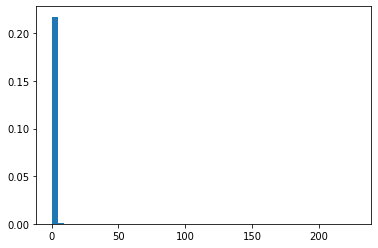

In [21]:
plt.hist(c,50, density=True)
plt.show()

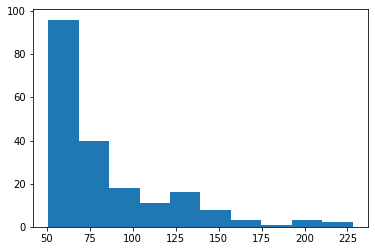

In [22]:
plt.hist(b1 [b1>50])
plt.show()

In [23]:
def F(x):
  prom=np.mean(x)
  desv=np.std(x)
  return desv/prom

In [24]:
f1=F(b1)
f1

6.677466598161514

#  **Universe evolved from $a_0=0.1$ to  $a=0.1$**

No handles with labels found to put in legend.


[]

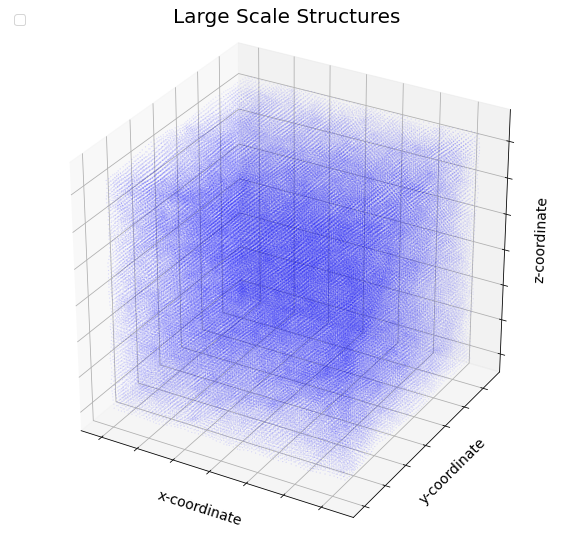

In [25]:
## Define key parameters of our Universe
a0      = 0.1       #the initial epoch from where we begin the evolution, a0=0 corresponds to birth but is numerically unstable
af      = 0.1       #final epoch where we visualize structures, af=1 corresponds to today
n_steps = 30        #number of time-steps to split the total evolution into
L       = 100       #Physical size of the Universe in Mpc/h
N       = 64        #Number of mesh-points along one axis, size of the cube. Then the number of particles will be N^3
batch   = 2         #Batch size, how many independent Universes to simulate

stages = np.linspace(a0, af, n_steps, endpoint=True) #time-steps for the integration

#Read-in the linear power-spectrum from a file. 
#This is determined by some fundamental parameters of our Universe that cosmologists are interested in
#In N-body simulations, this determines the clustering of the Universe at the initial epoch a0
klin = np.loadtxt('flowpm/flowpm/data/Planck15_a1p00.txt').T[0]
plin = np.loadtxt('flowpm/flowpm/data/Planck15_a1p00.txt').T[1]
ipklin = iuspline(klin, plin)

#tf.reset_default_graph()
# Generate Gaussian initial conditions for matter density 
initial_conditions = flowpm.linear_field(N,  L, ipklin, batch_size=batch)   

# Sample particles, i.e. generate the initial displacement and velocity
# State is a tensor of shape (3, batch, N^3, 3)
# where the last axiss corresponds to the 3: x, y, z directions 
# and the first axis corresponds to position, velocity, acceleration of particle
state = flowpm.lpt_init(initial_conditions, a0=a0)   

# Evolve particles from initial state down to a=af
final_state = flowpm.nbody(state, stages, N)         

# Retrieve final density field i.e interpolate the particles to the mesh
final_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), final_state[0])

#Execute the graph!
#with tf.Session() as sess:
ic, istate, fstate, sim = ([initial_conditions, state, final_state, final_field])

#Execute the graph!
with tf.Session() as sess:
    ic, istate, fstate, sim = sess.run([initial_conditions, state, final_state, final_field])

#Create figure
fig=plt.figure(figsize=(10,10))#Create 3D axes
try: ax=fig.add_subplot(111,projection="3d")
except : ax=Axes3D(fig) 
ax.scatter(fstate[0, 0,:,0],fstate[0, 0,:,1], fstate[0, 0,:,2],color="blue",marker=".",s=.02)
ax.set_xlabel("x-coordinate",fontsize=14)
ax.set_ylabel("y-coordinate",fontsize=14)
ax.set_zlabel("z-coordinate",fontsize=14)
ax.set_title("Large Scale Structures\n",fontsize=20)
ax.legend(loc="upper left",fontsize=14)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
#plt.savefig('3dfinal.png', dpi=1200)

In [26]:
d0_1=density(100);

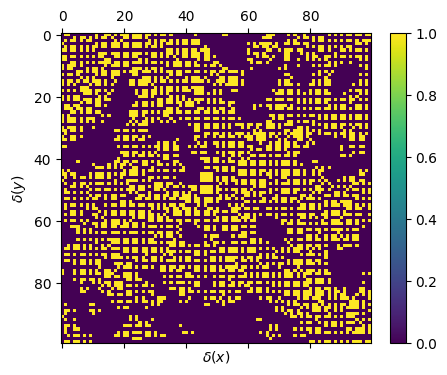

In [27]:
fig = plt.figure(figsize=(5,4), dpi=100)
plt.matshow(d0_1[49,:,:],fignum=1,cmap=plt.cm.viridis, aspect='auto')
plt.colorbar()
plt.xlabel(r'$\delta(x)$', fontsize=10)
plt.ylabel(r'$\delta(y)$', fontsize=10)
plt.show()

In [28]:
psd0_1, kpd0_1=PS(d0_1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


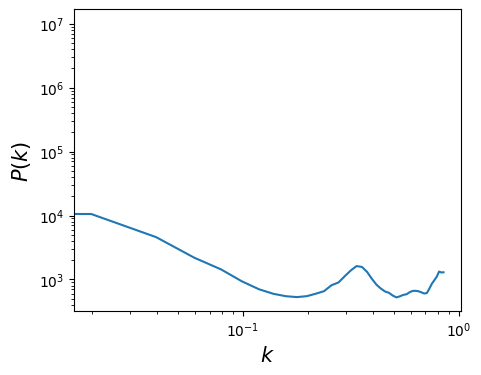

In [29]:
fig = plt.figure(figsize=(5,4), dpi=100)
plt.loglog(kpd0_1,psd0_1)

plt.xlabel(r'$k$', fontsize=15)
plt.ylabel(r'$P(k)$', fontsize=15)
plt.show()

In [30]:
b0_1 = d0_1.ravel()
len(b0_1)
f0_1=F(b0_1)
f0_1

1.681119916848574

# **Universe evolved from $a_0=0.1$ to  $a=0.5$**

No handles with labels found to put in legend.


[]

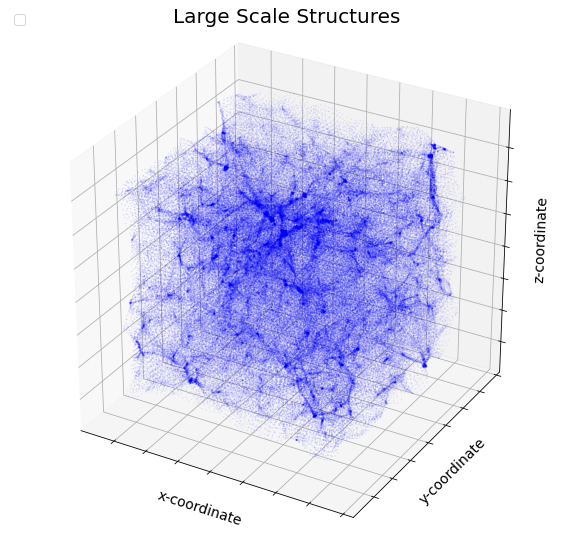

In [31]:
## Define key parameters of our Universe
a0      = 0.1       #the initial epoch from where we begin the evolution, a0=0 corresponds to birth but is numerically unstable
af      = 0.5       #final epoch where we visualize structures, af=1 corresponds to today
n_steps = 30        #number of time-steps to split the total evolution into
L       = 100       #Physical size of the Universe in Mpc/h
N       = 64        #Number of mesh-points along one axis, size of the cube. Then the number of particles will be N^3
batch   = 2         #Batch size, how many independent Universes to simulate

stages = np.linspace(a0, af, n_steps, endpoint=True) #time-steps for the integration

#Read-in the linear power-spectrum from a file. 
#This is determined by some fundamental parameters of our Universe that cosmologists are interested in
#In N-body simulations, this determines the clustering of the Universe at the initial epoch a0
klin = np.loadtxt('flowpm/flowpm/data/Planck15_a1p00.txt').T[0]
plin = np.loadtxt('flowpm/flowpm/data/Planck15_a1p00.txt').T[1]
ipklin = iuspline(klin, plin)

#tf.reset_default_graph()
# Generate Gaussian initial conditions for matter density 
initial_conditions = flowpm.linear_field(N,  L, ipklin, batch_size=batch)   

# Sample particles, i.e. generate the initial displacement and velocity
# State is a tensor of shape (3, batch, N^3, 3)
# where the last axiss corresponds to the 3: x, y, z directions 
# and the first axis corresponds to position, velocity, acceleration of particle
state = flowpm.lpt_init(initial_conditions, a0=a0)   

# Evolve particles from initial state down to a=af
final_state = flowpm.nbody(state, stages, N)         

# Retrieve final density field i.e interpolate the particles to the mesh
final_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), final_state[0])

#Execute the graph!
#with tf.Session() as sess:
ic, istate, fstate, sim = ([initial_conditions, state, final_state, final_field])

#Execute the graph!
with tf.Session() as sess:
    ic, istate, fstate, sim = sess.run([initial_conditions, state, final_state, final_field])

#Create figure
fig=plt.figure(figsize=(10,10))#Create 3D axes
try: ax=fig.add_subplot(111,projection="3d")
except : ax=Axes3D(fig) 
ax.scatter(fstate[0, 0,:,0],fstate[0, 0,:,1], fstate[0, 0,:,2],color="blue",marker=".",s=.02)
ax.set_xlabel("x-coordinate",fontsize=14)
ax.set_ylabel("y-coordinate",fontsize=14)
ax.set_zlabel("z-coordinate",fontsize=14)
ax.set_title("Large Scale Structures\n",fontsize=20)
ax.legend(loc="upper left",fontsize=14)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
#plt.savefig('3dfinal.png', dpi=1200)

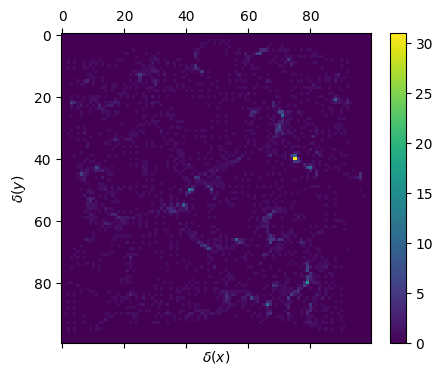

In [32]:
d0_5=density(100);
fig = plt.figure(figsize=(5,4), dpi=100)
plt.matshow(d0_5[49,:,:],fignum=1,cmap=plt.cm.viridis, aspect='auto')
plt.colorbar()
plt.xlabel(r'$\delta(x)$', fontsize=10)
plt.ylabel(r'$\delta(y)$', fontsize=10)
plt.show()

In [33]:
psd0_5, kpd0_5=PS(d0_5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


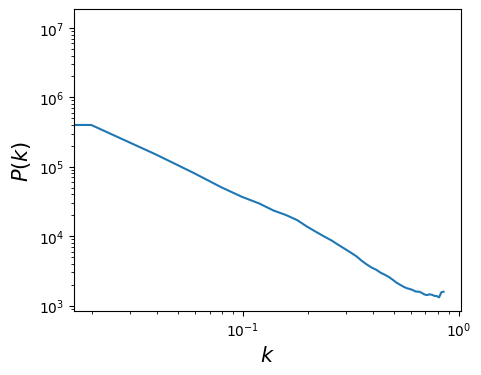

In [34]:
fig = plt.figure(figsize=(5,4), dpi=100)
plt.loglog(kpd0_5,psd0_5)

plt.xlabel(r'$k$', fontsize=15)
plt.ylabel(r'$P(k)$', fontsize=15)
plt.show()

In [35]:
b0_5 = d0_5.ravel()
len(b0_5)
f0_5=F(b0_5)
f0_5

3.9056176241173084

#  **Universe evolved from $a_0=0.1$ to  $a=0.2$**

No handles with labels found to put in legend.


[]

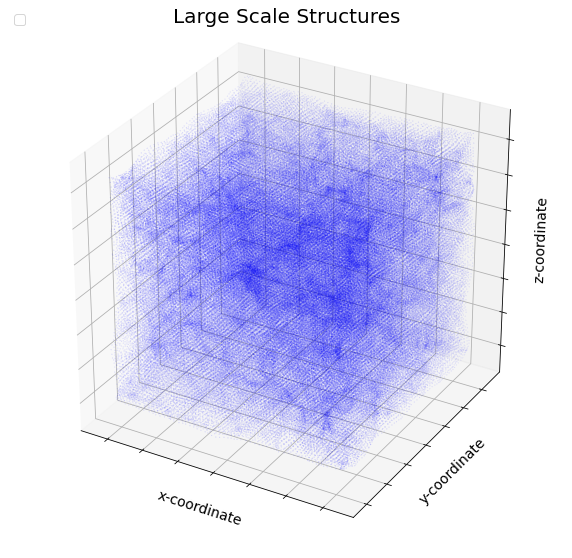

In [36]:
## Define key parameters of our Universe
a0      = 0.1       #the initial epoch from where we begin the evolution, a0=0 corresponds to birth but is numerically unstable
af      = 0.2       #final epoch where we visualize structures, af=1 corresponds to today
n_steps = 30        #number of time-steps to split the total evolution into
L       = 100       #Physical size of the Universe in Mpc/h
N       = 64        #Number of mesh-points along one axis, size of the cube. Then the number of particles will be N^3
batch   = 2         #Batch size, how many independent Universes to simulate

stages = np.linspace(a0, af, n_steps, endpoint=True) #time-steps for the integration

#Read-in the linear power-spectrum from a file. 
#This is determined by some fundamental parameters of our Universe that cosmologists are interested in
#In N-body simulations, this determines the clustering of the Universe at the initial epoch a0
klin = np.loadtxt('flowpm/flowpm/data/Planck15_a1p00.txt').T[0]
plin = np.loadtxt('flowpm/flowpm/data/Planck15_a1p00.txt').T[1]
ipklin = iuspline(klin, plin)

#tf.reset_default_graph()
# Generate Gaussian initial conditions for matter density 
initial_conditions = flowpm.linear_field(N,  L, ipklin, batch_size=batch)   

# Sample particles, i.e. generate the initial displacement and velocity
# State is a tensor of shape (3, batch, N^3, 3)
# where the last axiss corresponds to the 3: x, y, z directions 
# and the first axis corresponds to position, velocity, acceleration of particle
state = flowpm.lpt_init(initial_conditions, a0=a0)   

# Evolve particles from initial state down to a=af
final_state = flowpm.nbody(state, stages, N)         

# Retrieve final density field i.e interpolate the particles to the mesh
final_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), final_state[0])

#Execute the graph!
#with tf.Session() as sess:
ic, istate, fstate, sim = ([initial_conditions, state, final_state, final_field])

#Execute the graph!
with tf.Session() as sess:
    ic, istate, fstate, sim = sess.run([initial_conditions, state, final_state, final_field])

#Create figure
fig=plt.figure(figsize=(10,10))#Create 3D axes
try: ax=fig.add_subplot(111,projection="3d")
except : ax=Axes3D(fig) 
ax.scatter(fstate[0, 0,:,0],fstate[0, 0,:,1], fstate[0, 0,:,2],color="blue",marker=".",s=.02)
ax.set_xlabel("x-coordinate",fontsize=14)
ax.set_ylabel("y-coordinate",fontsize=14)
ax.set_zlabel("z-coordinate",fontsize=14)
ax.set_title("Large Scale Structures\n",fontsize=20)
ax.legend(loc="upper left",fontsize=14)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
#plt.savefig('3dfinal.png', dpi=1200)

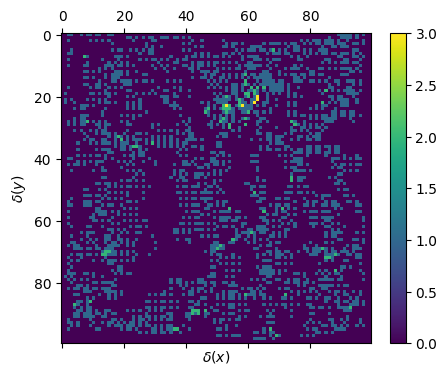

In [37]:
d0_2=density(100);
fig = plt.figure(figsize=(5,4), dpi=100)
plt.matshow(d0_2[49,:,:],fignum=1,cmap=plt.cm.viridis, aspect='auto')
plt.colorbar()
plt.xlabel(r'$\delta(x)$', fontsize=10)
plt.ylabel(r'$\delta(y)$', fontsize=10)
plt.show()

In [38]:
psd0_2, kpd0_2=PS(d0_2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


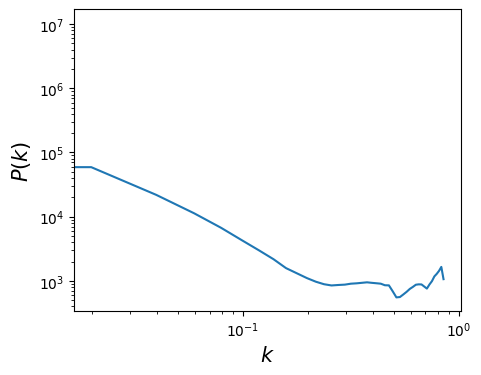

In [39]:
fig = plt.figure(figsize=(5,4), dpi=100)
plt.loglog(kpd0_2,psd0_2)

plt.xlabel(r'$k$', fontsize=15)
plt.ylabel(r'$P(k)$', fontsize=15)
plt.show()

In [40]:
b0_2 = d0_2.ravel()
len(b0_2)
f0_2=F(b0_2)
f0_2

1.8018964843316012

#  **Universe evolved from $a_0=0.1$ to  $a=0.3$**

No handles with labels found to put in legend.


[]

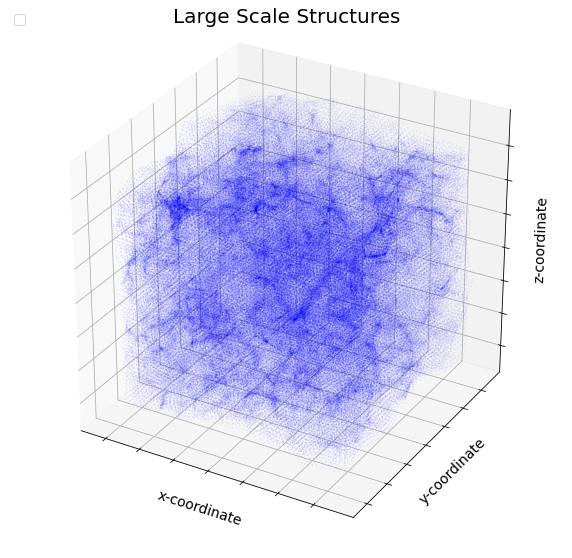

In [41]:
## Define key parameters of our Universe
a0      = 0.1       #the initial epoch from where we begin the evolution, a0=0 corresponds to birth but is numerically unstable
af      = 0.3       #final epoch where we visualize structures, af=1 corresponds to today
n_steps = 30        #number of time-steps to split the total evolution into
L       = 100       #Physical size of the Universe in Mpc/h
N       = 64        #Number of mesh-points along one axis, size of the cube. Then the number of particles will be N^3
batch   = 2         #Batch size, how many independent Universes to simulate

stages = np.linspace(a0, af, n_steps, endpoint=True) #time-steps for the integration

#Read-in the linear power-spectrum from a file. 
#This is determined by some fundamental parameters of our Universe that cosmologists are interested in
#In N-body simulations, this determines the clustering of the Universe at the initial epoch a0
klin = np.loadtxt('flowpm/flowpm/data/Planck15_a1p00.txt').T[0]
plin = np.loadtxt('flowpm/flowpm/data/Planck15_a1p00.txt').T[1]
ipklin = iuspline(klin, plin)

#tf.reset_default_graph()
# Generate Gaussian initial conditions for matter density 
initial_conditions = flowpm.linear_field(N,  L, ipklin, batch_size=batch)   

# Sample particles, i.e. generate the initial displacement and velocity
# State is a tensor of shape (3, batch, N^3, 3)
# where the last axiss corresponds to the 3: x, y, z directions 
# and the first axis corresponds to position, velocity, acceleration of particle
state = flowpm.lpt_init(initial_conditions, a0=a0)   

# Evolve particles from initial state down to a=af
final_state = flowpm.nbody(state, stages, N)         

# Retrieve final density field i.e interpolate the particles to the mesh
final_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), final_state[0])

#Execute the graph!
#with tf.Session() as sess:
ic, istate, fstate, sim = ([initial_conditions, state, final_state, final_field])

#Execute the graph!
with tf.Session() as sess:
    ic, istate, fstate, sim = sess.run([initial_conditions, state, final_state, final_field])

#Create figure
fig=plt.figure(figsize=(10,10))#Create 3D axes
try: ax=fig.add_subplot(111,projection="3d")
except : ax=Axes3D(fig) 
ax.scatter(fstate[0, 0,:,0],fstate[0, 0,:,1], fstate[0, 0,:,2],color="blue",marker=".",s=.02)
ax.set_xlabel("x-coordinate",fontsize=14)
ax.set_ylabel("y-coordinate",fontsize=14)
ax.set_zlabel("z-coordinate",fontsize=14)
ax.set_title("Large Scale Structures\n",fontsize=20)
ax.legend(loc="upper left",fontsize=14)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
#plt.savefig('3dfinal.png', dpi=1200)

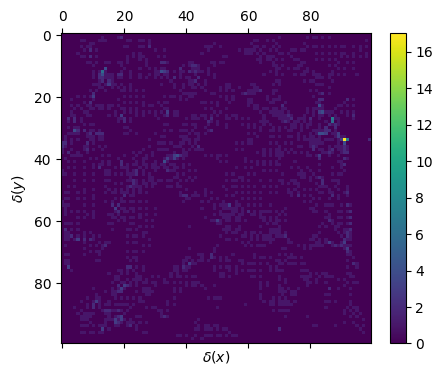

In [42]:
d0_3=density(100);
fig = plt.figure(figsize=(5,4), dpi=100)
plt.matshow(d0_3[49,:,:],fignum=1,cmap=plt.cm.viridis, aspect='auto')
plt.colorbar()
plt.xlabel(r'$\delta(x)$', fontsize=10)
plt.ylabel(r'$\delta(y)$', fontsize=10)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


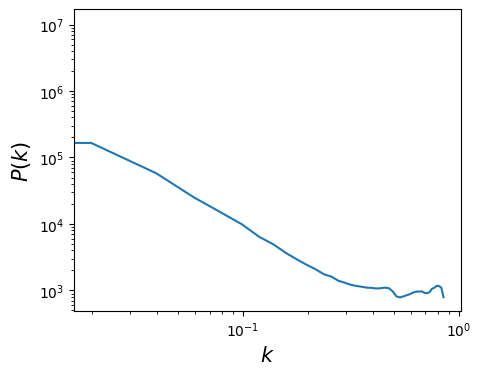

In [43]:
psd0_3, kpd0_3=PS(d0_3)

fig = plt.figure(figsize=(5,4), dpi=100)
plt.loglog(kpd0_3,psd0_3)

plt.xlabel(r'$k$', fontsize=15)
plt.ylabel(r'$P(k)$', fontsize=15)
plt.show()

In [44]:
b0_3 = d0_3.ravel()
len(b0_3)
f0_3=F(b0_3)
f0_3

2.164202939048669

# **Universe evolved from $a_0=0.1$ to  $a=0.4$**

No handles with labels found to put in legend.


[]

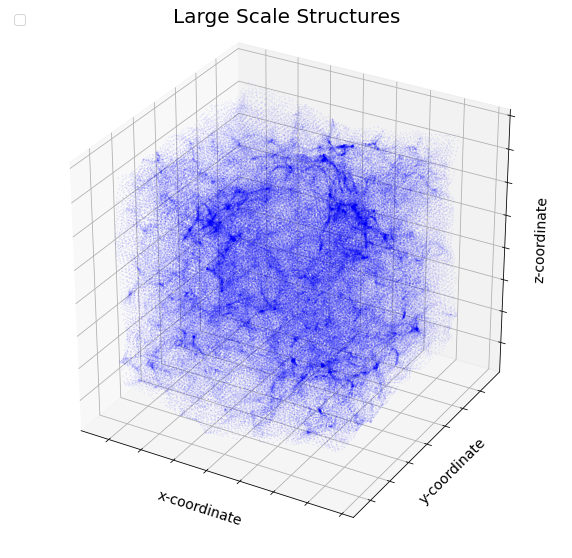

In [45]:
## Define key parameters of our Universe
a0      = 0.1       #the initial epoch from where we begin the evolution, a0=0 corresponds to birth but is numerically unstable
af      = 0.4       #final epoch where we visualize structures, af=1 corresponds to today
n_steps = 30        #number of time-steps to split the total evolution into
L       = 100       #Physical size of the Universe in Mpc/h
N       = 64        #Number of mesh-points along one axis, size of the cube. Then the number of particles will be N^3
batch   = 2         #Batch size, how many independent Universes to simulate

stages = np.linspace(a0, af, n_steps, endpoint=True) #time-steps for the integration

#Read-in the linear power-spectrum from a file. 
#This is determined by some fundamental parameters of our Universe that cosmologists are interested in
#In N-body simulations, this determines the clustering of the Universe at the initial epoch a0
klin = np.loadtxt('flowpm/flowpm/data/Planck15_a1p00.txt').T[0]
plin = np.loadtxt('flowpm/flowpm/data/Planck15_a1p00.txt').T[1]
ipklin = iuspline(klin, plin)

#tf.reset_default_graph()
# Generate Gaussian initial conditions for matter density 
initial_conditions = flowpm.linear_field(N,  L, ipklin, batch_size=batch)   

# Sample particles, i.e. generate the initial displacement and velocity
# State is a tensor of shape (3, batch, N^3, 3)
# where the last axiss corresponds to the 3: x, y, z directions 
# and the first axis corresponds to position, velocity, acceleration of particle
state = flowpm.lpt_init(initial_conditions, a0=a0)   

# Evolve particles from initial state down to a=af
final_state = flowpm.nbody(state, stages, N)         

# Retrieve final density field i.e interpolate the particles to the mesh
final_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), final_state[0])

#Execute the graph!
#with tf.Session() as sess:
ic, istate, fstate, sim = ([initial_conditions, state, final_state, final_field])

#Execute the graph!
with tf.Session() as sess:
    ic, istate, fstate, sim = sess.run([initial_conditions, state, final_state, final_field])

#Create figure
fig=plt.figure(figsize=(10,10))#Create 3D axes
try: ax=fig.add_subplot(111,projection="3d")
except : ax=Axes3D(fig) 
ax.scatter(fstate[0, 0,:,0],fstate[0, 0,:,1], fstate[0, 0,:,2],color="blue",marker=".",s=.02)
ax.set_xlabel("x-coordinate",fontsize=14)
ax.set_ylabel("y-coordinate",fontsize=14)
ax.set_zlabel("z-coordinate",fontsize=14)
ax.set_title("Large Scale Structures\n",fontsize=20)
ax.legend(loc="upper left",fontsize=14)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
#plt.savefig('3dfinal.png', dpi=1200)

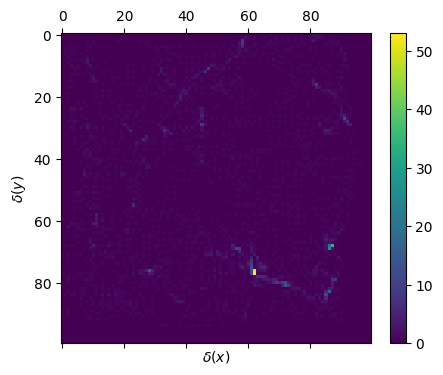

In [46]:
d0_4=density(100);
fig = plt.figure(figsize=(5,4), dpi=100)
plt.matshow(d0_4[49,:,:],fignum=1,cmap=plt.cm.viridis, aspect='auto')
plt.colorbar()
plt.xlabel(r'$\delta(x)$', fontsize=10)
plt.ylabel(r'$\delta(y)$', fontsize=10)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


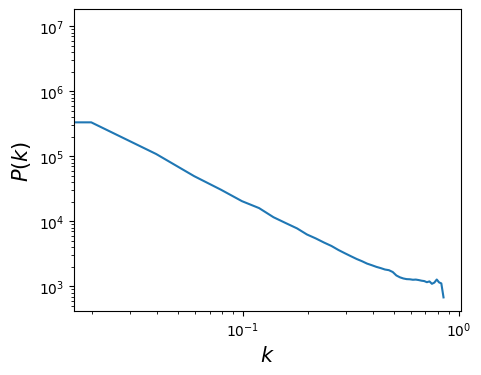

In [47]:
psd0_4, kpd0_4=PS(d0_4)

fig = plt.figure(figsize=(5,4), dpi=100)
plt.loglog(kpd0_4,psd0_4)

plt.xlabel(r'$k$', fontsize=15)
plt.ylabel(r'$P(k)$', fontsize=15)
plt.show()

In [48]:
b0_4 = d0_4.ravel()
len(b0_4)
f0_4=F(b0_4)
f0_4

3.0144377027109424

# **Universe evolved from $a_0=0.1$ to $a=0.6$**

No handles with labels found to put in legend.


[]

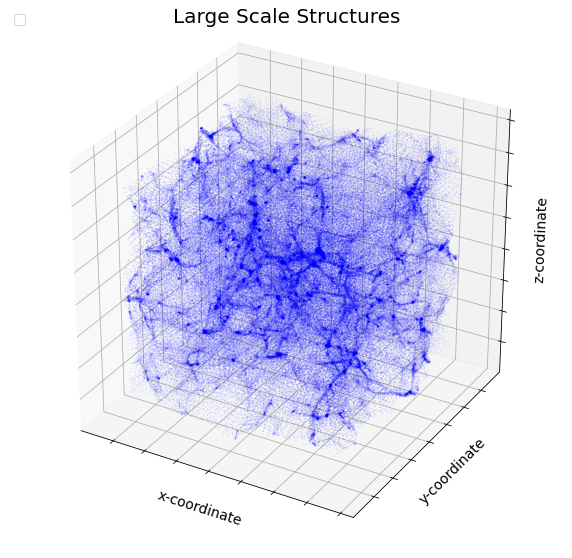

In [49]:
## Define key parameters of our Universe
a0      = 0.1       #the initial epoch from where we begin the evolution, a0=0 corresponds to birth but is numerically unstable
af      = 0.6       #final epoch where we visualize structures, af=1 corresponds to today
n_steps = 30        #number of time-steps to split the total evolution into
L       = 100       #Physical size of the Universe in Mpc/h
N       = 64        #Number of mesh-points along one axis, size of the cube. Then the number of particles will be N^3
batch   = 2         #Batch size, how many independent Universes to simulate

stages = np.linspace(a0, af, n_steps, endpoint=True) #time-steps for the integration

#Read-in the linear power-spectrum from a file. 
#This is determined by some fundamental parameters of our Universe that cosmologists are interested in
#In N-body simulations, this determines the clustering of the Universe at the initial epoch a0
klin = np.loadtxt('flowpm/flowpm/data/Planck15_a1p00.txt').T[0]
plin = np.loadtxt('flowpm/flowpm/data/Planck15_a1p00.txt').T[1]
ipklin = iuspline(klin, plin)

#tf.reset_default_graph()
# Generate Gaussian initial conditions for matter density 
initial_conditions = flowpm.linear_field(N,  L, ipklin, batch_size=batch)   

# Sample particles, i.e. generate the initial displacement and velocity
# State is a tensor of shape (3, batch, N^3, 3)
# where the last axiss corresponds to the 3: x, y, z directions 
# and the first axis corresponds to position, velocity, acceleration of particle
state = flowpm.lpt_init(initial_conditions, a0=a0)   

# Evolve particles from initial state down to a=af
final_state = flowpm.nbody(state, stages, N)         

# Retrieve final density field i.e interpolate the particles to the mesh
final_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), final_state[0])

#Execute the graph!
#with tf.Session() as sess:
ic, istate, fstate, sim = ([initial_conditions, state, final_state, final_field])

#Execute the graph!
with tf.Session() as sess:
    ic, istate, fstate, sim = sess.run([initial_conditions, state, final_state, final_field])

#Create figure
fig=plt.figure(figsize=(10,10))#Create 3D axes
try: ax=fig.add_subplot(111,projection="3d")
except : ax=Axes3D(fig) 
ax.scatter(fstate[0, 0,:,0],fstate[0, 0,:,1], fstate[0, 0,:,2],color="blue",marker=".",s=.02)
ax.set_xlabel("x-coordinate",fontsize=14)
ax.set_ylabel("y-coordinate",fontsize=14)
ax.set_zlabel("z-coordinate",fontsize=14)
ax.set_title("Large Scale Structures\n",fontsize=20)
ax.legend(loc="upper left",fontsize=14)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
#plt.savefig('3dfinal.png', dpi=1200)

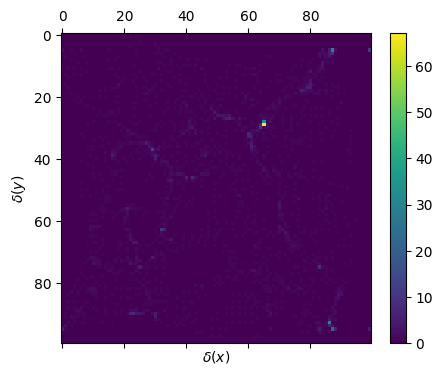

In [50]:
d0_6=density(100);
fig = plt.figure(figsize=(5,4), dpi=100)
plt.matshow(d0_6[49,:,:],fignum=1,cmap=plt.cm.viridis, aspect='auto')
plt.colorbar()
plt.xlabel(r'$\delta(x)$', fontsize=10)
plt.ylabel(r'$\delta(y)$', fontsize=10)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


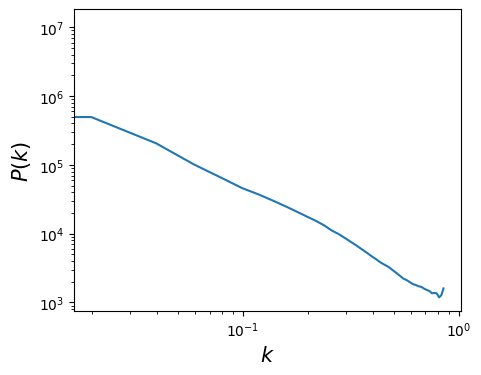

In [51]:
psd0_6, kpd0_6=PS(d0_6)

fig = plt.figure(figsize=(5,4), dpi=100)
plt.loglog(kpd0_6,psd0_6)

plt.xlabel(r'$k$', fontsize=15)
plt.ylabel(r'$P(k)$', fontsize=15)
plt.show()

In [52]:
b0_6 = d0_6.ravel()
len(b0_6)
f0_6=F(b0_6)
f0_6

4.39361477153874

# **Universe evolved from  $a_0=0.1$ to  $𝑎=0.7$**

No handles with labels found to put in legend.


[]

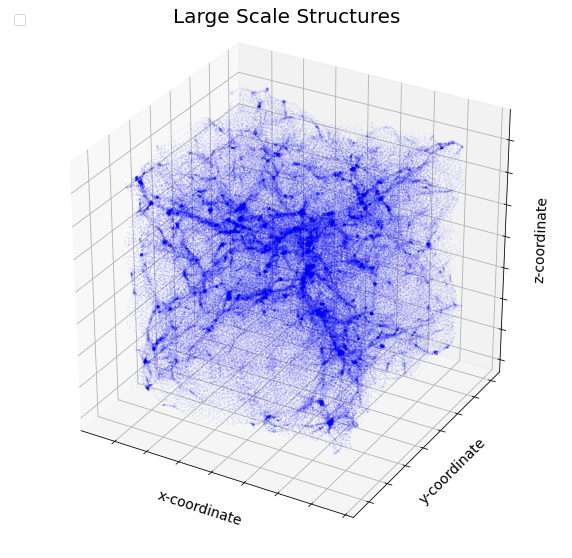

In [53]:
## Define key parameters of our Universe
a0      = 0.1       #the initial epoch from where we begin the evolution, a0=0 corresponds to birth but is numerically unstable
af      = 0.7       #final epoch where we visualize structures, af=1 corresponds to today
n_steps = 30        #number of time-steps to split the total evolution into
L       = 100       #Physical size of the Universe in Mpc/h
N       = 64        #Number of mesh-points along one axis, size of the cube. Then the number of particles will be N^3
batch   = 2         #Batch size, how many independent Universes to simulate

stages = np.linspace(a0, af, n_steps, endpoint=True) #time-steps for the integration

#Read-in the linear power-spectrum from a file. 
#This is determined by some fundamental parameters of our Universe that cosmologists are interested in
#In N-body simulations, this determines the clustering of the Universe at the initial epoch a0
klin = np.loadtxt('flowpm/flowpm/data/Planck15_a1p00.txt').T[0]
plin = np.loadtxt('flowpm/flowpm/data/Planck15_a1p00.txt').T[1]
ipklin = iuspline(klin, plin)

#tf.reset_default_graph()
# Generate Gaussian initial conditions for matter density 
initial_conditions = flowpm.linear_field(N,  L, ipklin, batch_size=batch)   

# Sample particles, i.e. generate the initial displacement and velocity
# State is a tensor of shape (3, batch, N^3, 3)
# where the last axiss corresponds to the 3: x, y, z directions 
# and the first axis corresponds to position, velocity, acceleration of particle
state = flowpm.lpt_init(initial_conditions, a0=a0)   

# Evolve particles from initial state down to a=af
final_state = flowpm.nbody(state, stages, N)         

# Retrieve final density field i.e interpolate the particles to the mesh
final_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), final_state[0])

#Execute the graph!
#with tf.Session() as sess:
ic, istate, fstate, sim = ([initial_conditions, state, final_state, final_field])

#Execute the graph!
with tf.Session() as sess:
    ic, istate, fstate, sim = sess.run([initial_conditions, state, final_state, final_field])

#Create figure
fig=plt.figure(figsize=(10,10))#Create 3D axes
try: ax=fig.add_subplot(111,projection="3d")
except : ax=Axes3D(fig) 
ax.scatter(fstate[0, 0,:,0],fstate[0, 0,:,1], fstate[0, 0,:,2],color="blue",marker=".",s=.02)
ax.set_xlabel("x-coordinate",fontsize=14)
ax.set_ylabel("y-coordinate",fontsize=14)
ax.set_zlabel("z-coordinate",fontsize=14)
ax.set_title("Large Scale Structures\n",fontsize=20)
ax.legend(loc="upper left",fontsize=14)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
#plt.savefig('3dfinal.png', dpi=1200)

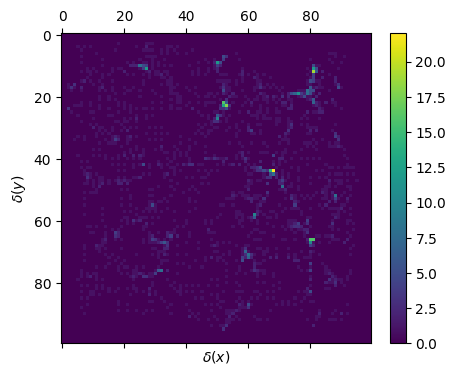

In [54]:
d0_7=density(100);
fig = plt.figure(figsize=(5,4), dpi=100)
plt.matshow(d0_7[49,:,:],fignum=1,cmap=plt.cm.viridis, aspect='auto')
plt.colorbar()
plt.xlabel(r'$\delta(x)$', fontsize=10)
plt.ylabel(r'$\delta(y)$', fontsize=10)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


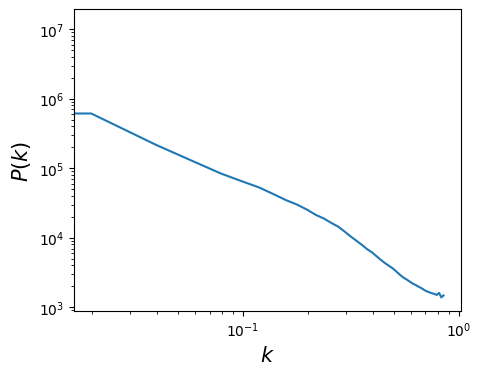

In [55]:
psd0_7, kpd0_7=PS(d0_7)

fig = plt.figure(figsize=(5,4), dpi=100)
plt.loglog(kpd0_7,psd0_7)

plt.xlabel(r'$k$', fontsize=15)
plt.ylabel(r'$P(k)$', fontsize=15)
plt.show()

In [56]:
b0_7 = d0_7.ravel()
len(b0_7)
f0_7=F(b0_7)
f0_7

5.044069231030725

# **Universe evolved from  $a_0=0.1$ to  $𝑎=0.8$**

No handles with labels found to put in legend.


[]

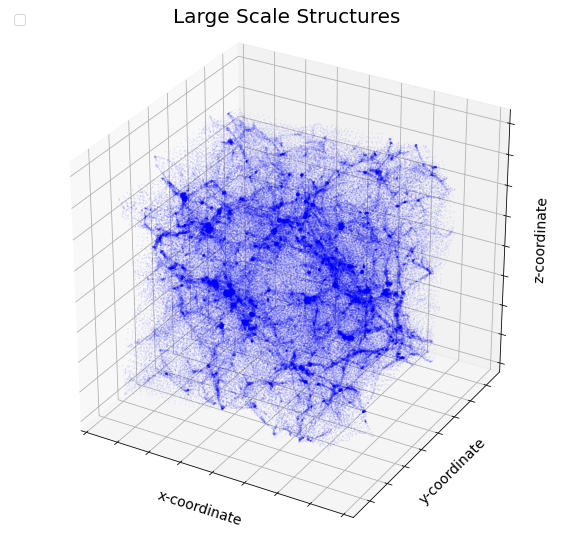

In [57]:
## Define key parameters of our Universe
a0      = 0.1       #the initial epoch from where we begin the evolution, a0=0 corresponds to birth but is numerically unstable
af      = 0.8       #final epoch where we visualize structures, af=1 corresponds to today
n_steps = 30        #number of time-steps to split the total evolution into
L       = 100       #Physical size of the Universe in Mpc/h
N       = 64        #Number of mesh-points along one axis, size of the cube. Then the number of particles will be N^3
batch   = 2         #Batch size, how many independent Universes to simulate

stages = np.linspace(a0, af, n_steps, endpoint=True) #time-steps for the integration

#Read-in the linear power-spectrum from a file. 
#This is determined by some fundamental parameters of our Universe that cosmologists are interested in
#In N-body simulations, this determines the clustering of the Universe at the initial epoch a0
klin = np.loadtxt('flowpm/flowpm/data/Planck15_a1p00.txt').T[0]
plin = np.loadtxt('flowpm/flowpm/data/Planck15_a1p00.txt').T[1]
ipklin = iuspline(klin, plin)

#tf.reset_default_graph()
# Generate Gaussian initial conditions for matter density 
initial_conditions = flowpm.linear_field(N,  L, ipklin, batch_size=batch)   

# Sample particles, i.e. generate the initial displacement and velocity
# State is a tensor of shape (3, batch, N^3, 3)
# where the last axiss corresponds to the 3: x, y, z directions 
# and the first axis corresponds to position, velocity, acceleration of particle
state = flowpm.lpt_init(initial_conditions, a0=a0)   

# Evolve particles from initial state down to a=af
final_state = flowpm.nbody(state, stages, N)         

# Retrieve final density field i.e interpolate the particles to the mesh
final_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), final_state[0])

#Execute the graph!
#with tf.Session() as sess:
ic, istate, fstate, sim = ([initial_conditions, state, final_state, final_field])

#Execute the graph!
with tf.Session() as sess:
    ic, istate, fstate, sim = sess.run([initial_conditions, state, final_state, final_field])

#Create figure
fig=plt.figure(figsize=(10,10))#Create 3D axes
try: ax=fig.add_subplot(111,projection="3d")
except : ax=Axes3D(fig) 
ax.scatter(fstate[0, 0,:,0],fstate[0, 0,:,1], fstate[0, 0,:,2],color="blue",marker=".",s=.02)
ax.set_xlabel("x-coordinate",fontsize=14)
ax.set_ylabel("y-coordinate",fontsize=14)
ax.set_zlabel("z-coordinate",fontsize=14)
ax.set_title("Large Scale Structures\n",fontsize=20)
ax.legend(loc="upper left",fontsize=14)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
#plt.savefig('3dfinal.png', dpi=1200)

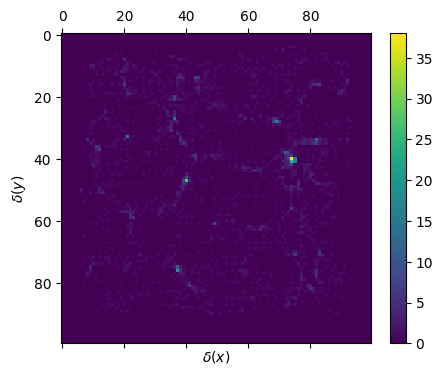

In [58]:
d0_8=density(100);
fig = plt.figure(figsize=(5,4), dpi=100)
plt.matshow(d0_8[49,:,:],fignum=1,cmap=plt.cm.viridis, aspect='auto')
plt.colorbar()
plt.xlabel(r'$\delta(x)$', fontsize=10)
plt.ylabel(r'$\delta(y)$', fontsize=10)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


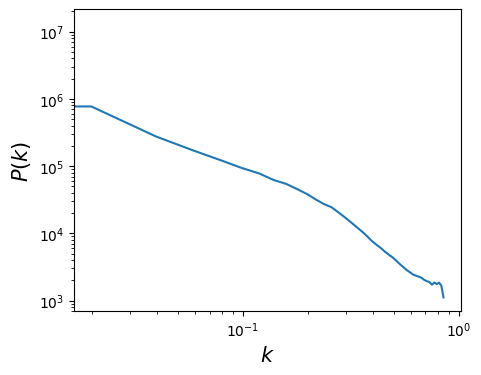

In [59]:
psd0_8, kpd0_8=PS(d0_8)

fig = plt.figure(figsize=(5,4), dpi=100)
plt.loglog(kpd0_8,psd0_8)

plt.xlabel(r'$k$', fontsize=15)
plt.ylabel(r'$P(k)$', fontsize=15)
plt.show()

In [60]:
b0_8 = d0_8.ravel()
len(b0_8)
f0_8=F(b0_8)
f0_8

5.869075726072525

# **Universe evolved from  $a_0=0.1$ to  $𝑎=0.9$**

No handles with labels found to put in legend.


[]

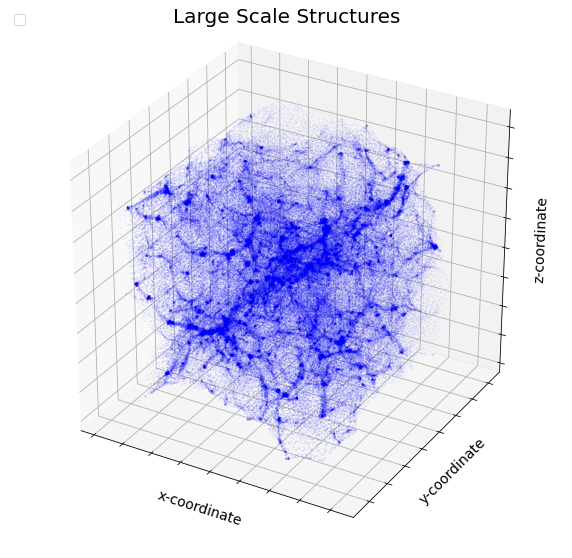

In [61]:
## Define key parameters of our Universe
a0      = 0.1       #the initial epoch from where we begin the evolution, a0=0 corresponds to birth but is numerically unstable
af      = 0.9       #final epoch where we visualize structures, af=1 corresponds to today
n_steps = 30        #number of time-steps to split the total evolution into
L       = 100       #Physical size of the Universe in Mpc/h
N       = 64        #Number of mesh-points along one axis, size of the cube. Then the number of particles will be N^3
batch   = 2         #Batch size, how many independent Universes to simulate

stages = np.linspace(a0, af, n_steps, endpoint=True) #time-steps for the integration

#Read-in the linear power-spectrum from a file. 
#This is determined by some fundamental parameters of our Universe that cosmologists are interested in
#In N-body simulations, this determines the clustering of the Universe at the initial epoch a0
klin = np.loadtxt('flowpm/flowpm/data/Planck15_a1p00.txt').T[0]
plin = np.loadtxt('flowpm/flowpm/data/Planck15_a1p00.txt').T[1]
ipklin = iuspline(klin, plin)

#tf.reset_default_graph()
# Generate Gaussian initial conditions for matter density 
initial_conditions = flowpm.linear_field(N,  L, ipklin, batch_size=batch)   

# Sample particles, i.e. generate the initial displacement and velocity
# State is a tensor of shape (3, batch, N^3, 3)
# where the last axiss corresponds to the 3: x, y, z directions 
# and the first axis corresponds to position, velocity, acceleration of particle
state = flowpm.lpt_init(initial_conditions, a0=a0)   

# Evolve particles from initial state down to a=af
final_state = flowpm.nbody(state, stages, N)         

# Retrieve final density field i.e interpolate the particles to the mesh
final_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), final_state[0])

#Execute the graph!
#with tf.Session() as sess:
ic, istate, fstate, sim = ([initial_conditions, state, final_state, final_field])

#Execute the graph!
with tf.Session() as sess:
    ic, istate, fstate, sim = sess.run([initial_conditions, state, final_state, final_field])

#Create figure
fig=plt.figure(figsize=(10,10))#Create 3D axes
try: ax=fig.add_subplot(111,projection="3d")
except : ax=Axes3D(fig) 
ax.scatter(fstate[0, 0,:,0],fstate[0, 0,:,1], fstate[0, 0,:,2],color="blue",marker=".",s=.02)
ax.set_xlabel("x-coordinate",fontsize=14)
ax.set_ylabel("y-coordinate",fontsize=14)
ax.set_zlabel("z-coordinate",fontsize=14)
ax.set_title("Large Scale Structures\n",fontsize=20)
ax.legend(loc="upper left",fontsize=14)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
#plt.savefig('3dfinal.png', dpi=1200)

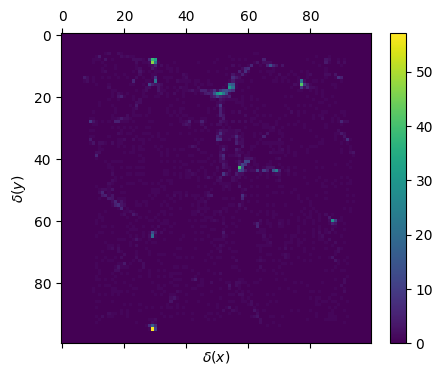

In [62]:
d0_9=density(100);
fig = plt.figure(figsize=(5,4), dpi=100)
plt.matshow(d0_9[49,:,:],fignum=1,cmap=plt.cm.viridis, aspect='auto')
plt.colorbar()
plt.xlabel(r'$\delta(x)$', fontsize=10)
plt.ylabel(r'$\delta(y)$', fontsize=10)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


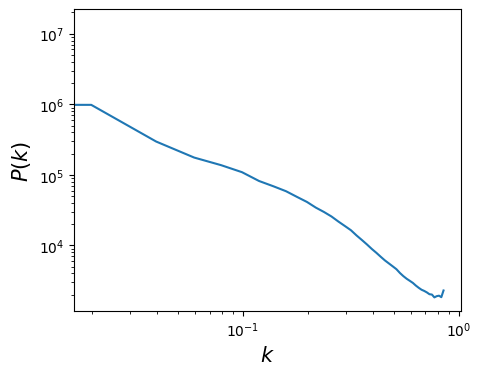

In [63]:
psd0_9, kpd0_9=PS(d0_9)

fig = plt.figure(figsize=(5,4), dpi=100)
plt.loglog(kpd0_9,psd0_9)

plt.xlabel(r'$k$', fontsize=15)
plt.ylabel(r'$P(k)$', fontsize=15)
plt.show()

In [64]:
b0_9 = d0_9.ravel()
len(b0_9)
f0_9=F(b0_9)
f0_9

6.198560880374719

# **Universe evolved form $a_0=0.05$ to  $a=0.1$**

No handles with labels found to put in legend.


[]

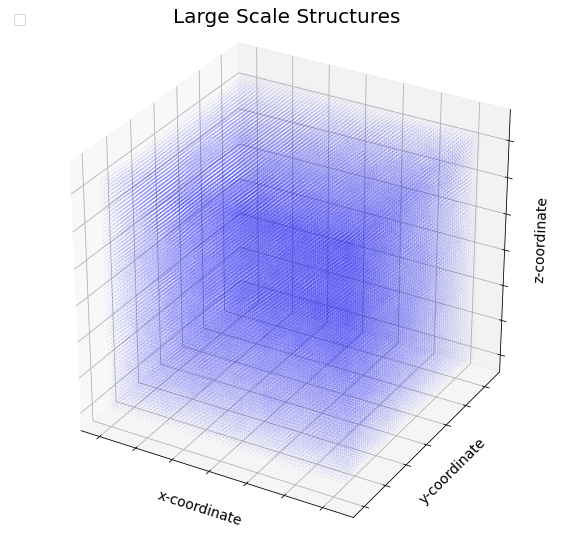

In [65]:
## Define key parameters of our Universe
a0      = 0.05       #the initial epoch from where we begin the evolution, a0=0 corresponds to birth but is numerically unstable
af      = 0.05      #final epoch where we visualize structures, af=1 corresponds to today
n_steps = 30        #number of time-steps to split the total evolution into
L       = 100       #Physical size of the Universe in Mpc/h
N       = 64        #Number of mesh-points along one axis, size of the cube. Then the number of particles will be N^3
batch   = 2         #Batch size, how many independent Universes to simulate

stages = np.linspace(a0, af, n_steps, endpoint=True) #time-steps for the integration

#Read-in the linear power-spectrum from a file. 
#This is determined by some fundamental parameters of our Universe that cosmologists are interested in
#In N-body simulations, this determines the clustering of the Universe at the initial epoch a0
klin = np.loadtxt('flowpm/flowpm/data/Planck15_a1p00.txt').T[0]
plin = np.loadtxt('flowpm/flowpm/data/Planck15_a1p00.txt').T[1]
ipklin = iuspline(klin, plin)

#tf.reset_default_graph()
# Generate Gaussian initial conditions for matter density 
initial_conditions = flowpm.linear_field(N,  L, ipklin, batch_size=batch)   

# Sample particles, i.e. generate the initial displacement and velocity
# State is a tensor of shape (3, batch, N^3, 3)
# where the last axiss corresponds to the 3: x, y, z directions 
# and the first axis corresponds to position, velocity, acceleration of particle
state = flowpm.lpt_init(initial_conditions, a0=a0)   

# Evolve particles from initial state down to a=af
final_state = flowpm.nbody(state, stages, N)         

# Retrieve final density field i.e interpolate the particles to the mesh
final_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), final_state[0])

#Execute the graph!
#with tf.Session() as sess:
ic, istate, fstate, sim = ([initial_conditions, state, final_state, final_field])

#Execute the graph!
with tf.Session() as sess:
    ic, istate, fstate, sim = sess.run([initial_conditions, state, final_state, final_field])

#Create figure
fig=plt.figure(figsize=(10,10))#Create 3D axes
try: ax=fig.add_subplot(111,projection="3d")
except : ax=Axes3D(fig) 
ax.scatter(fstate[0, 0,:,0],fstate[0, 0,:,1], fstate[0, 0,:,2],color="blue",marker=".",s=.02)
ax.set_xlabel("x-coordinate",fontsize=14)
ax.set_ylabel("y-coordinate",fontsize=14)
ax.set_zlabel("z-coordinate",fontsize=14)
ax.set_title("Large Scale Structures\n",fontsize=20)
ax.legend(loc="upper left",fontsize=14)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
#plt.savefig('3dfinal.png', dpi=1200)

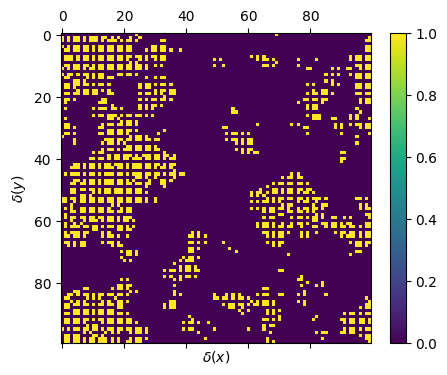

In [66]:
d0_05=density(100);
fig = plt.figure(figsize=(5,4), dpi=100)
plt.matshow(d0_05[49,:,:],fignum=1,cmap=plt.cm.viridis, aspect='auto')
plt.colorbar()
plt.xlabel(r'$\delta(x)$', fontsize=10)
plt.ylabel(r'$\delta(y)$', fontsize=10)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


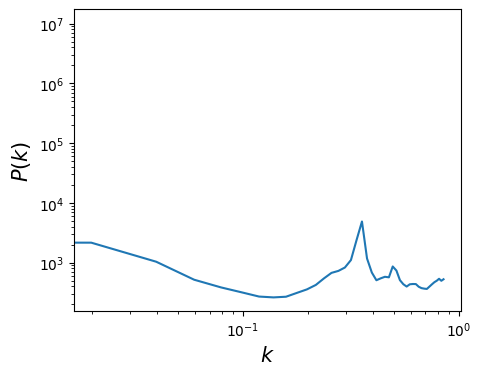

In [67]:
psd0_05, kpd0_05=PS(d0_05)

fig = plt.figure(figsize=(5,4), dpi=100)
plt.loglog(kpd0_05,psd0_05)

plt.xlabel(r'$k$', fontsize=15)
plt.ylabel(r'$P(k)$', fontsize=15)
plt.show()

In [72]:
b0_05 = d0_05.ravel()
len(b0_05)
f0_05=F(b0_05)
f0_05

1.6777146269420968

# **Histograms**

In [ ]:
x1=d0_9[49,:,:]
x1.shape

(100, 100)

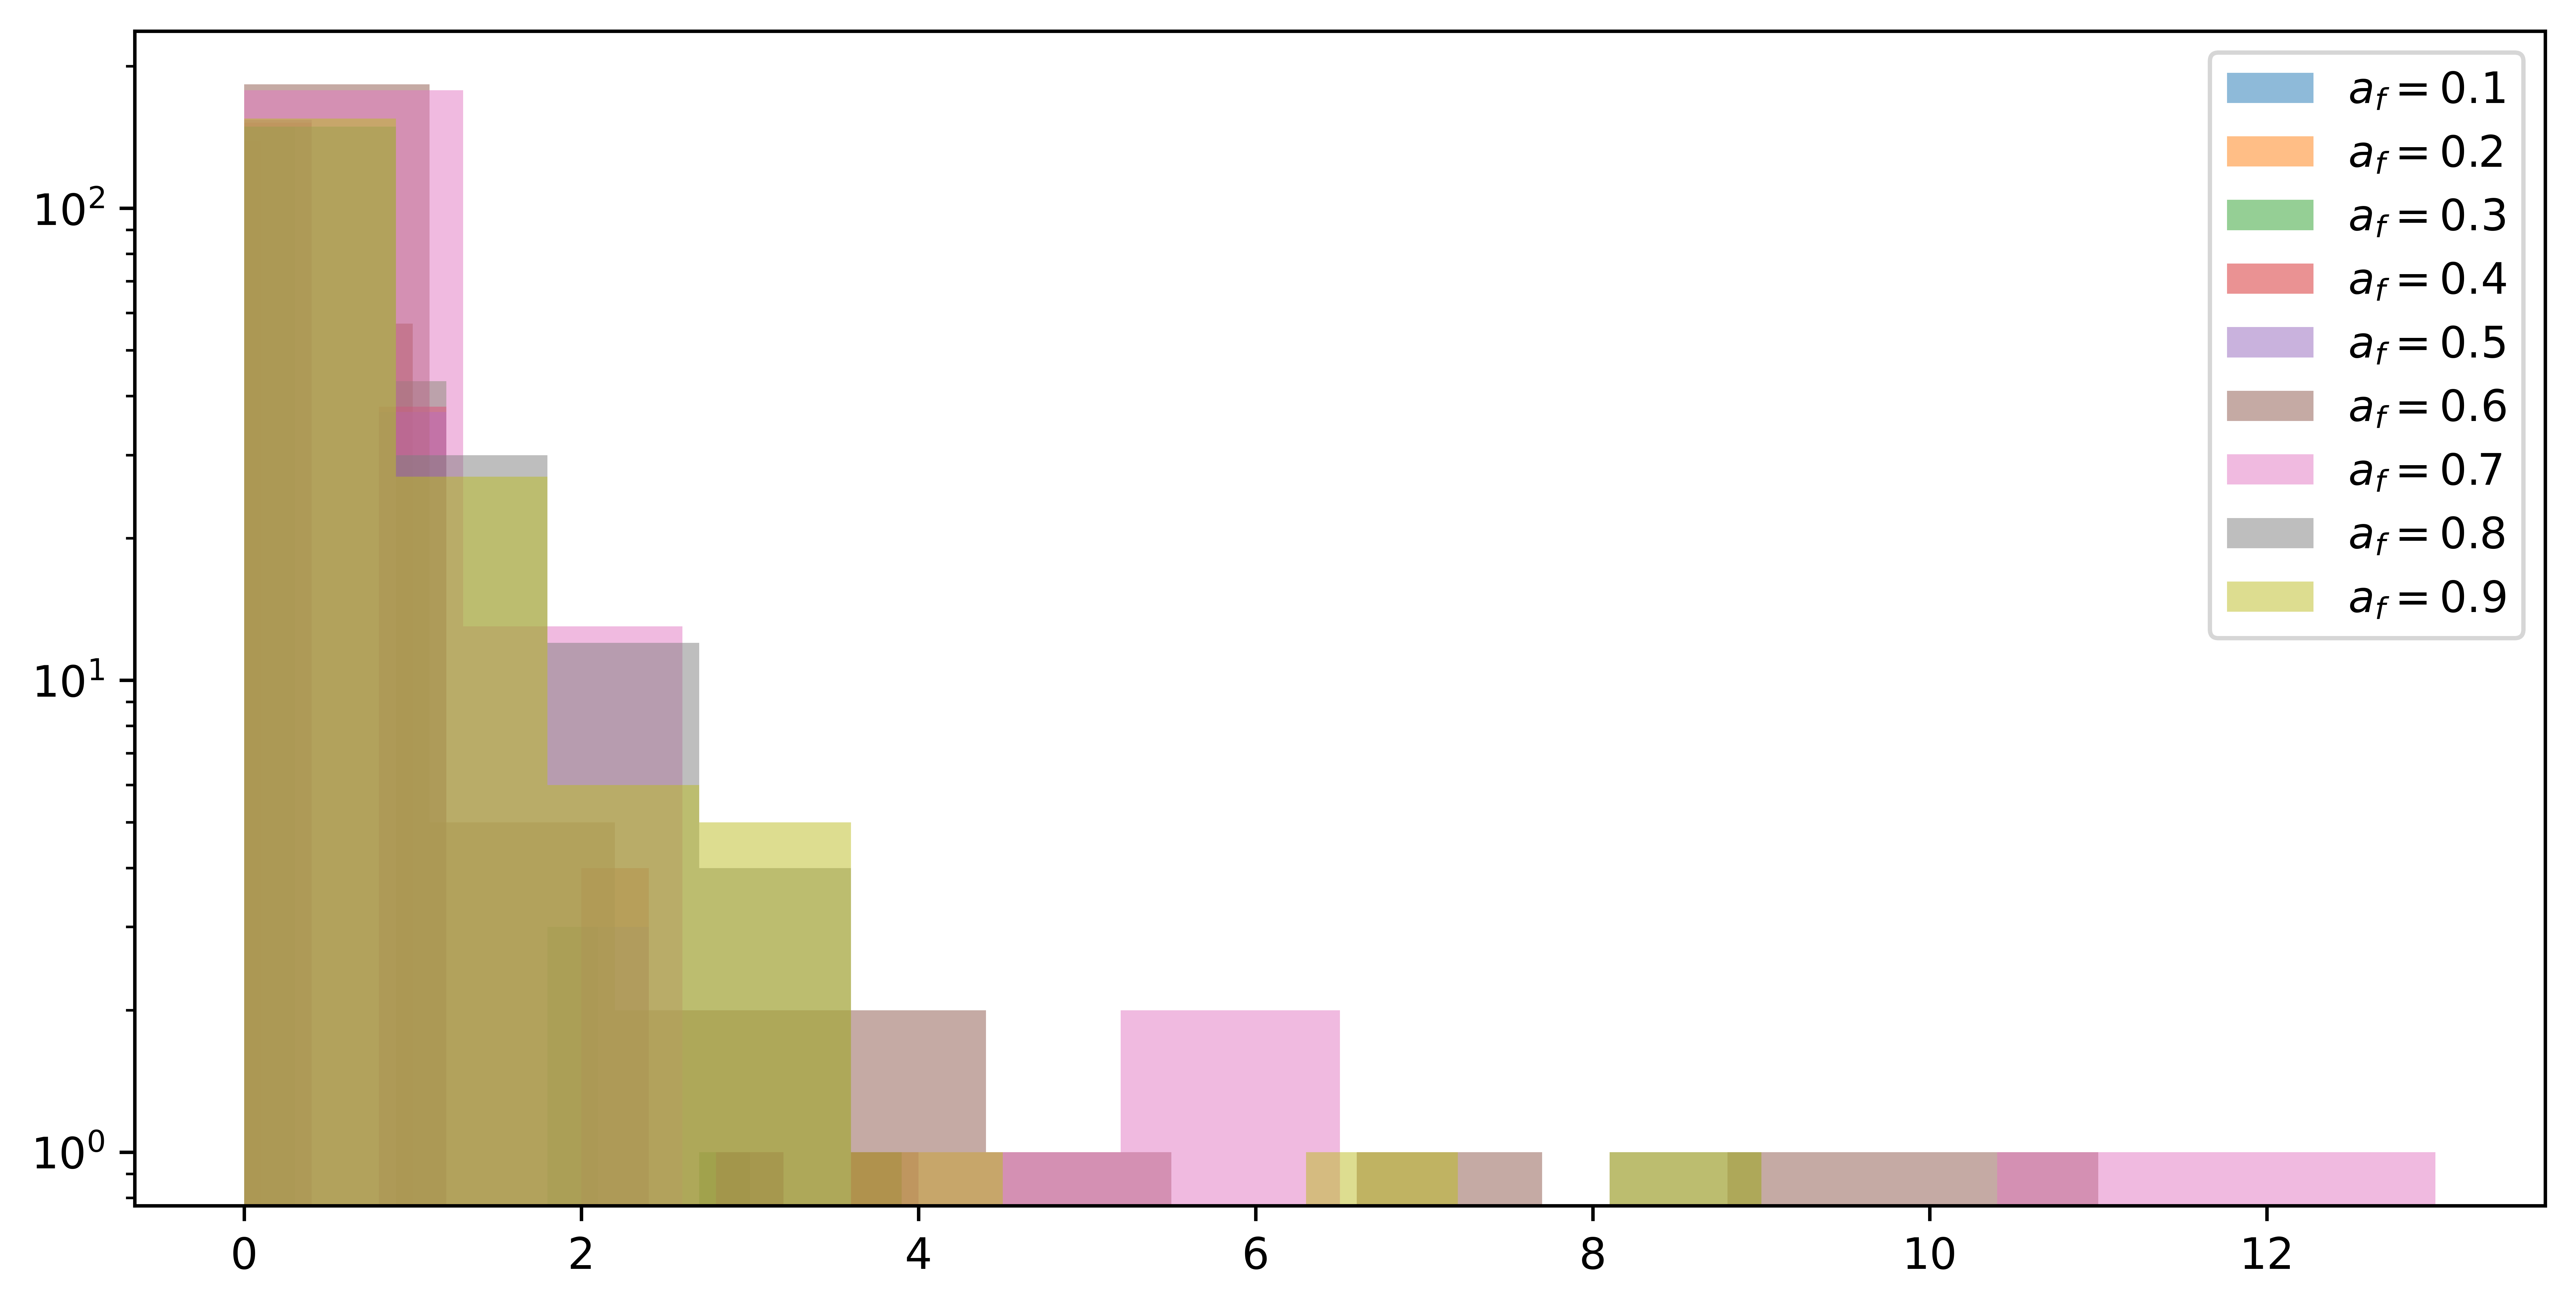

In [ ]:
fig = plt.figure(figsize=(10,5), dpi=1000)
#plt.hist(b1 [b1>80], label='$a_f=1.0$', alpha=0.5)
hc0_1=plt.hist(b0_1 [b1>50], label='$a_f=0.1$', alpha=0.5)
hc0_2=plt.hist(b0_2 [b1>50], label='$a_f=0.2$', alpha=0.5)
hc0_3=plt.hist(b0_3 [b1>50], label='$a_f=0.3$', alpha=0.5)
hc0_4=plt.hist(b0_4 [b1>50], label='$a_f=0.4$', alpha=0.5)
hc0_5=plt.hist(b0_5 [b1>50], label='$a_f=0.5$', alpha=0.5)
hc0_6=plt.hist(b0_6 [b1>50], label='$a_f=0.6$', alpha=0.5)
hc0_7=plt.hist(b0_7 [b1>50], label='$a_f=0.7$', alpha=0.5)
hc0_8=plt.hist(b0_8 [b1>50], label='$a_f=0.8$', alpha=0.5)
hc0_9=plt.hist(b0_9 [b1>50], label='$a_f=0.9$', alpha=0.5)
plt.yscale('log')
plt.legend()
plt.show()
 

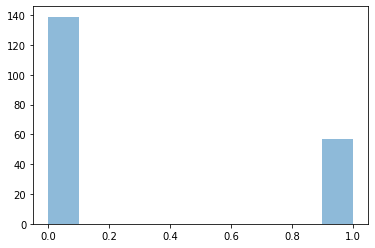

In [ ]:
hc0_1=plt.hist(b0_1 [b1>50], label='$a_f=0.1$', alpha=0.5)

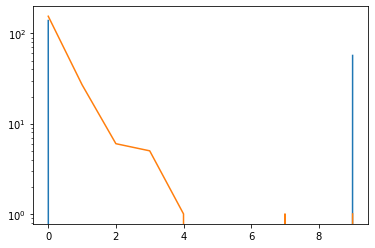

In [ ]:
plt.plot(hc0_1[0])
#plt.plot(hc0_2[0])
#plt.plot(hc0_3[0])
#plt.plot(hc0_4[0])
#plt.plot(hc0_5[0])
#plt.plot(hc0_6[0])
#plt.plot(hc0_7[0])
#plt.plot(hc0_8[0])
plt.plot(hc0_9[0])
plt.yscale('log')

# **Power Spectrum P(k)**

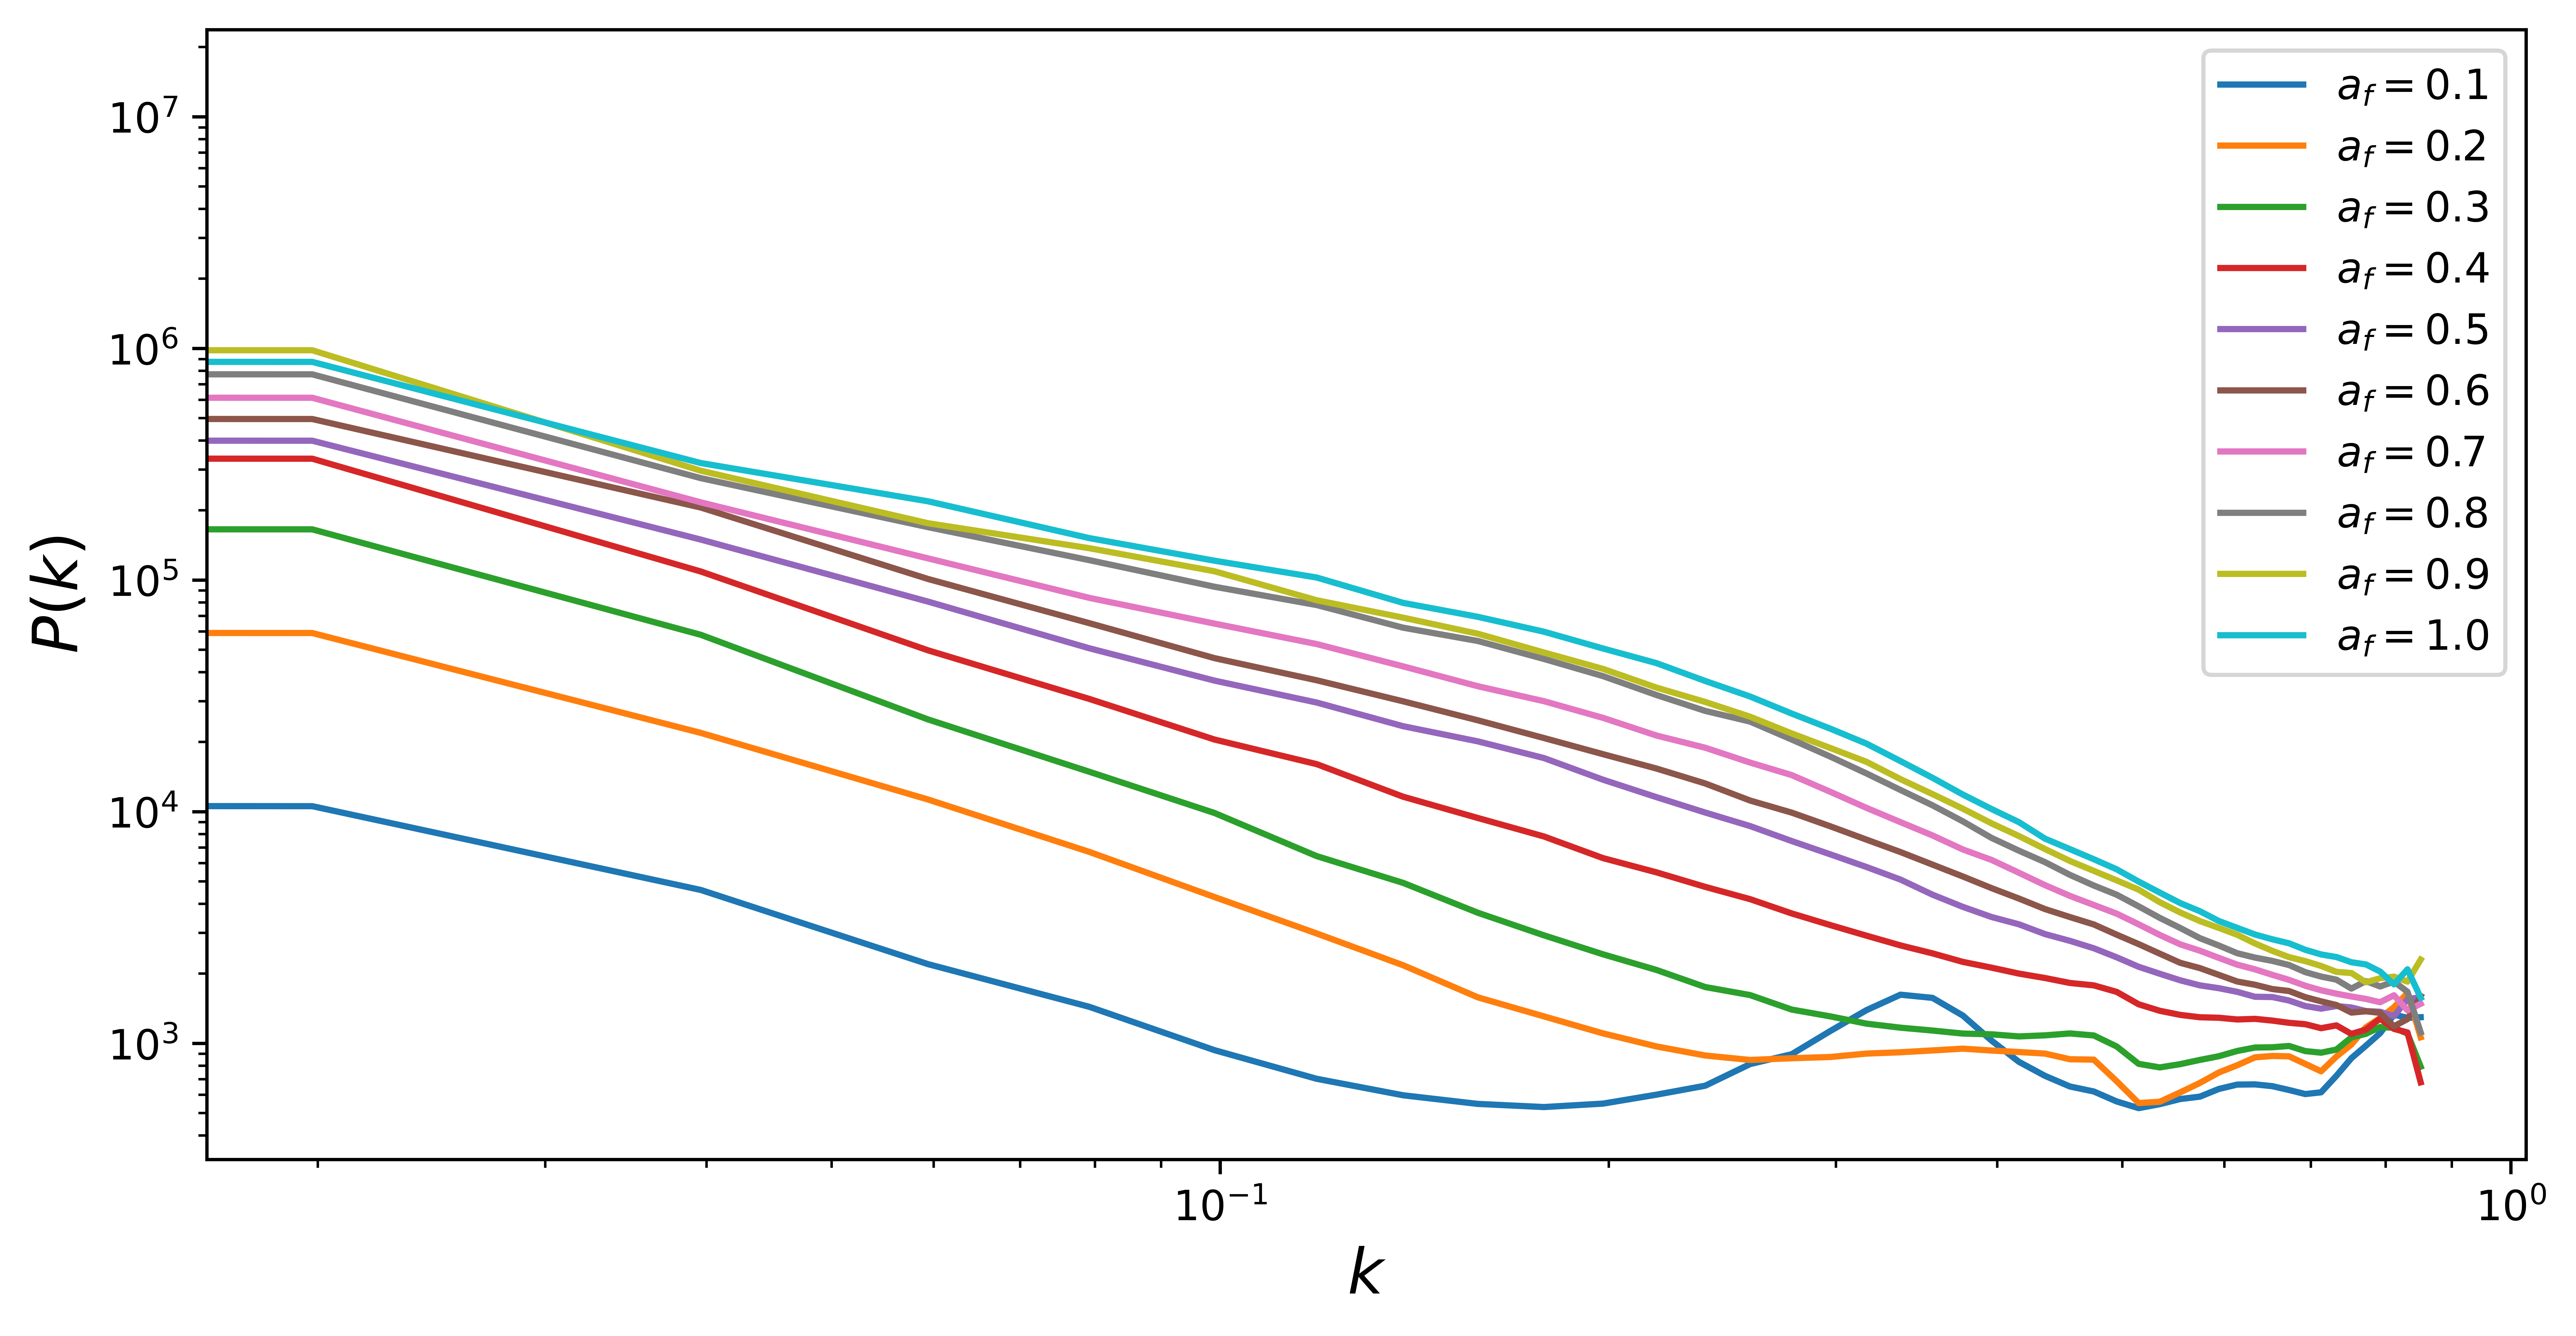

In [68]:
fig = plt.figure(figsize=(10,5), dpi=1000)
plt.loglog(kpd0_1,psd0_1, label=r'$a_f=0.1$')
plt.loglog(kpd0_2,psd0_2, label=r'$a_f=0.2$')
plt.loglog(kpd0_3,psd0_3, label=r'$a_f=0.3$')
plt.loglog(kpd0_4,psd0_4, label=r'$a_f=0.4$')
plt.loglog(kpd0_5,psd0_5, label=r'$a_f=0.5$')
plt.loglog(kpd0_6,psd0_6, label=r'$a_f=0.6$')
plt.loglog(kpd0_7,psd0_7, label=r'$a_f=0.7$')
plt.loglog(kpd0_8,psd0_8, label=r'$a_f=0.8$')
plt.loglog(kpd0_9,psd0_9, label=r'$a_f=0.9$')
plt.loglog(kpd1,psd1, label=r'$a_f=1.0$')

plt.xlabel(r'$k$', fontsize=15)
plt.ylabel(r'$P(k)$', fontsize=15)
plt.legend(loc='best')
plt.show()

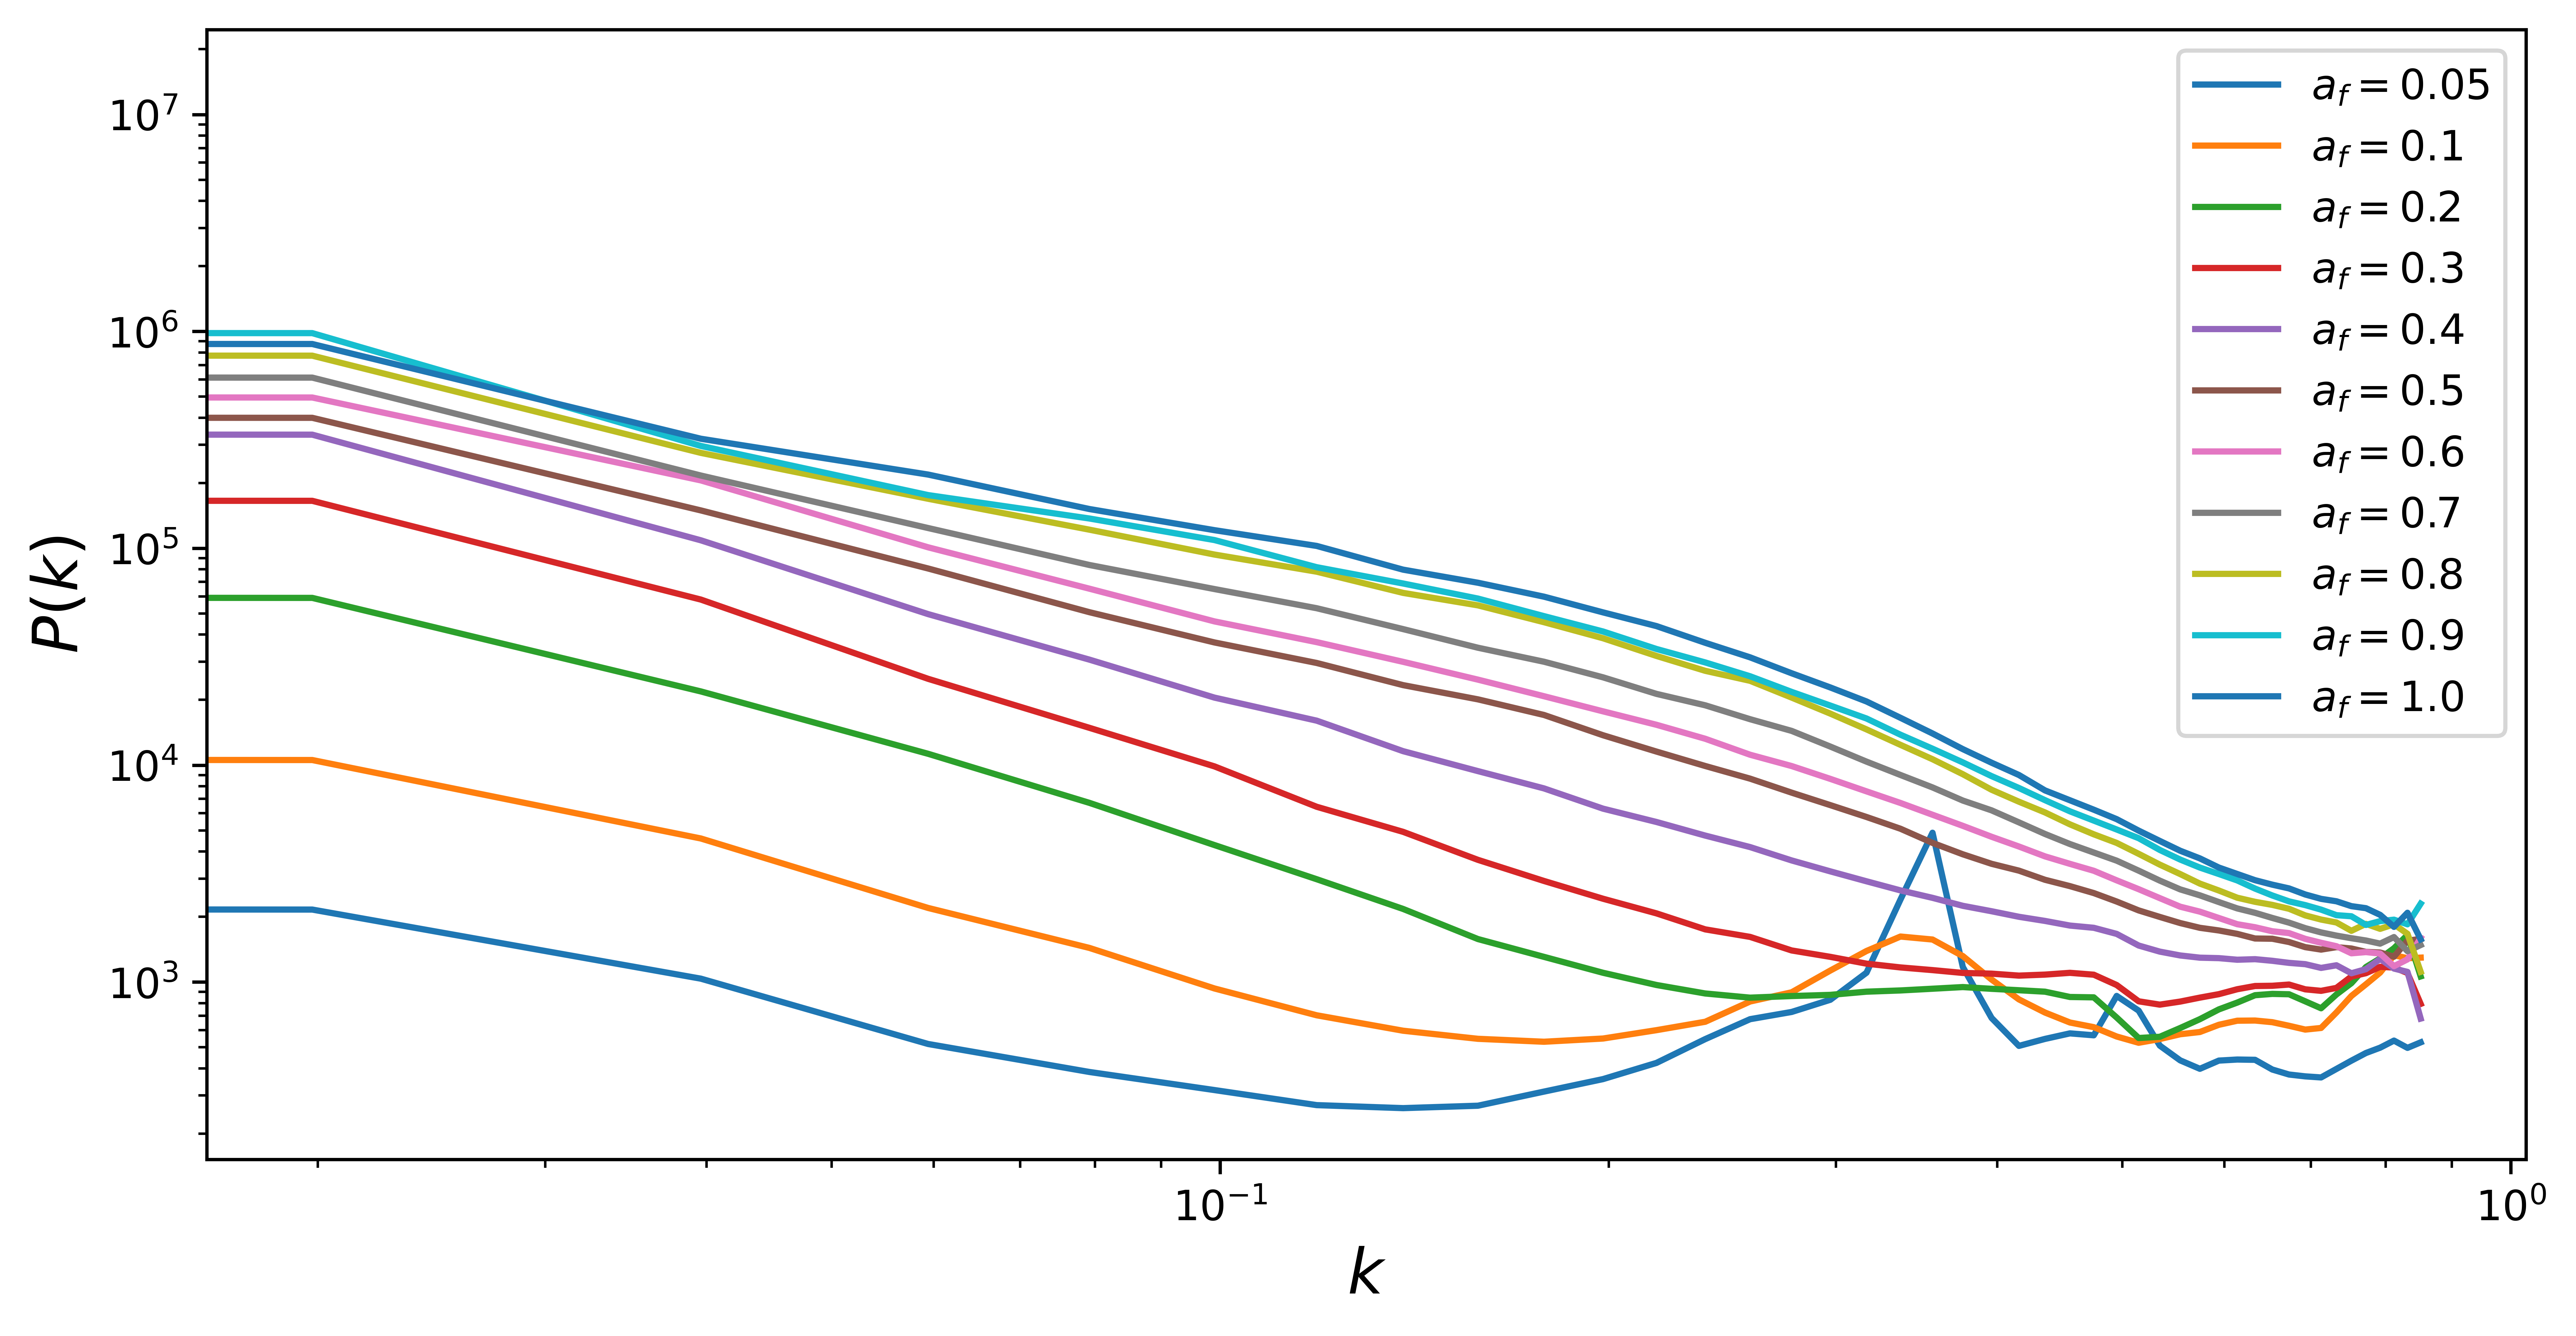

In [69]:
fig = plt.figure(figsize=(10,5), dpi=1000)
plt.loglog(kpd0_05,psd0_05, label=r'$a_f=0.05$')
plt.loglog(kpd0_1,psd0_1, label=r'$a_f=0.1$')
plt.loglog(kpd0_2,psd0_2, label=r'$a_f=0.2$')
plt.loglog(kpd0_3,psd0_3, label=r'$a_f=0.3$')
plt.loglog(kpd0_4,psd0_4, label=r'$a_f=0.4$')
plt.loglog(kpd0_5,psd0_5, label=r'$a_f=0.5$')
plt.loglog(kpd0_6,psd0_6, label=r'$a_f=0.6$')
plt.loglog(kpd0_7,psd0_7, label=r'$a_f=0.7$')
plt.loglog(kpd0_8,psd0_8, label=r'$a_f=0.8$')
plt.loglog(kpd0_9,psd0_9, label=r'$a_f=0.9$')
plt.loglog(kpd1,psd1, label=r'$a_f=1.0$')

plt.xlabel(r'$k$', fontsize=15)
plt.ylabel(r'$P(k)$', fontsize=15)
plt.legend(loc='best')
plt.show()

# **Fano**

Text(0, 0.5, 'F')

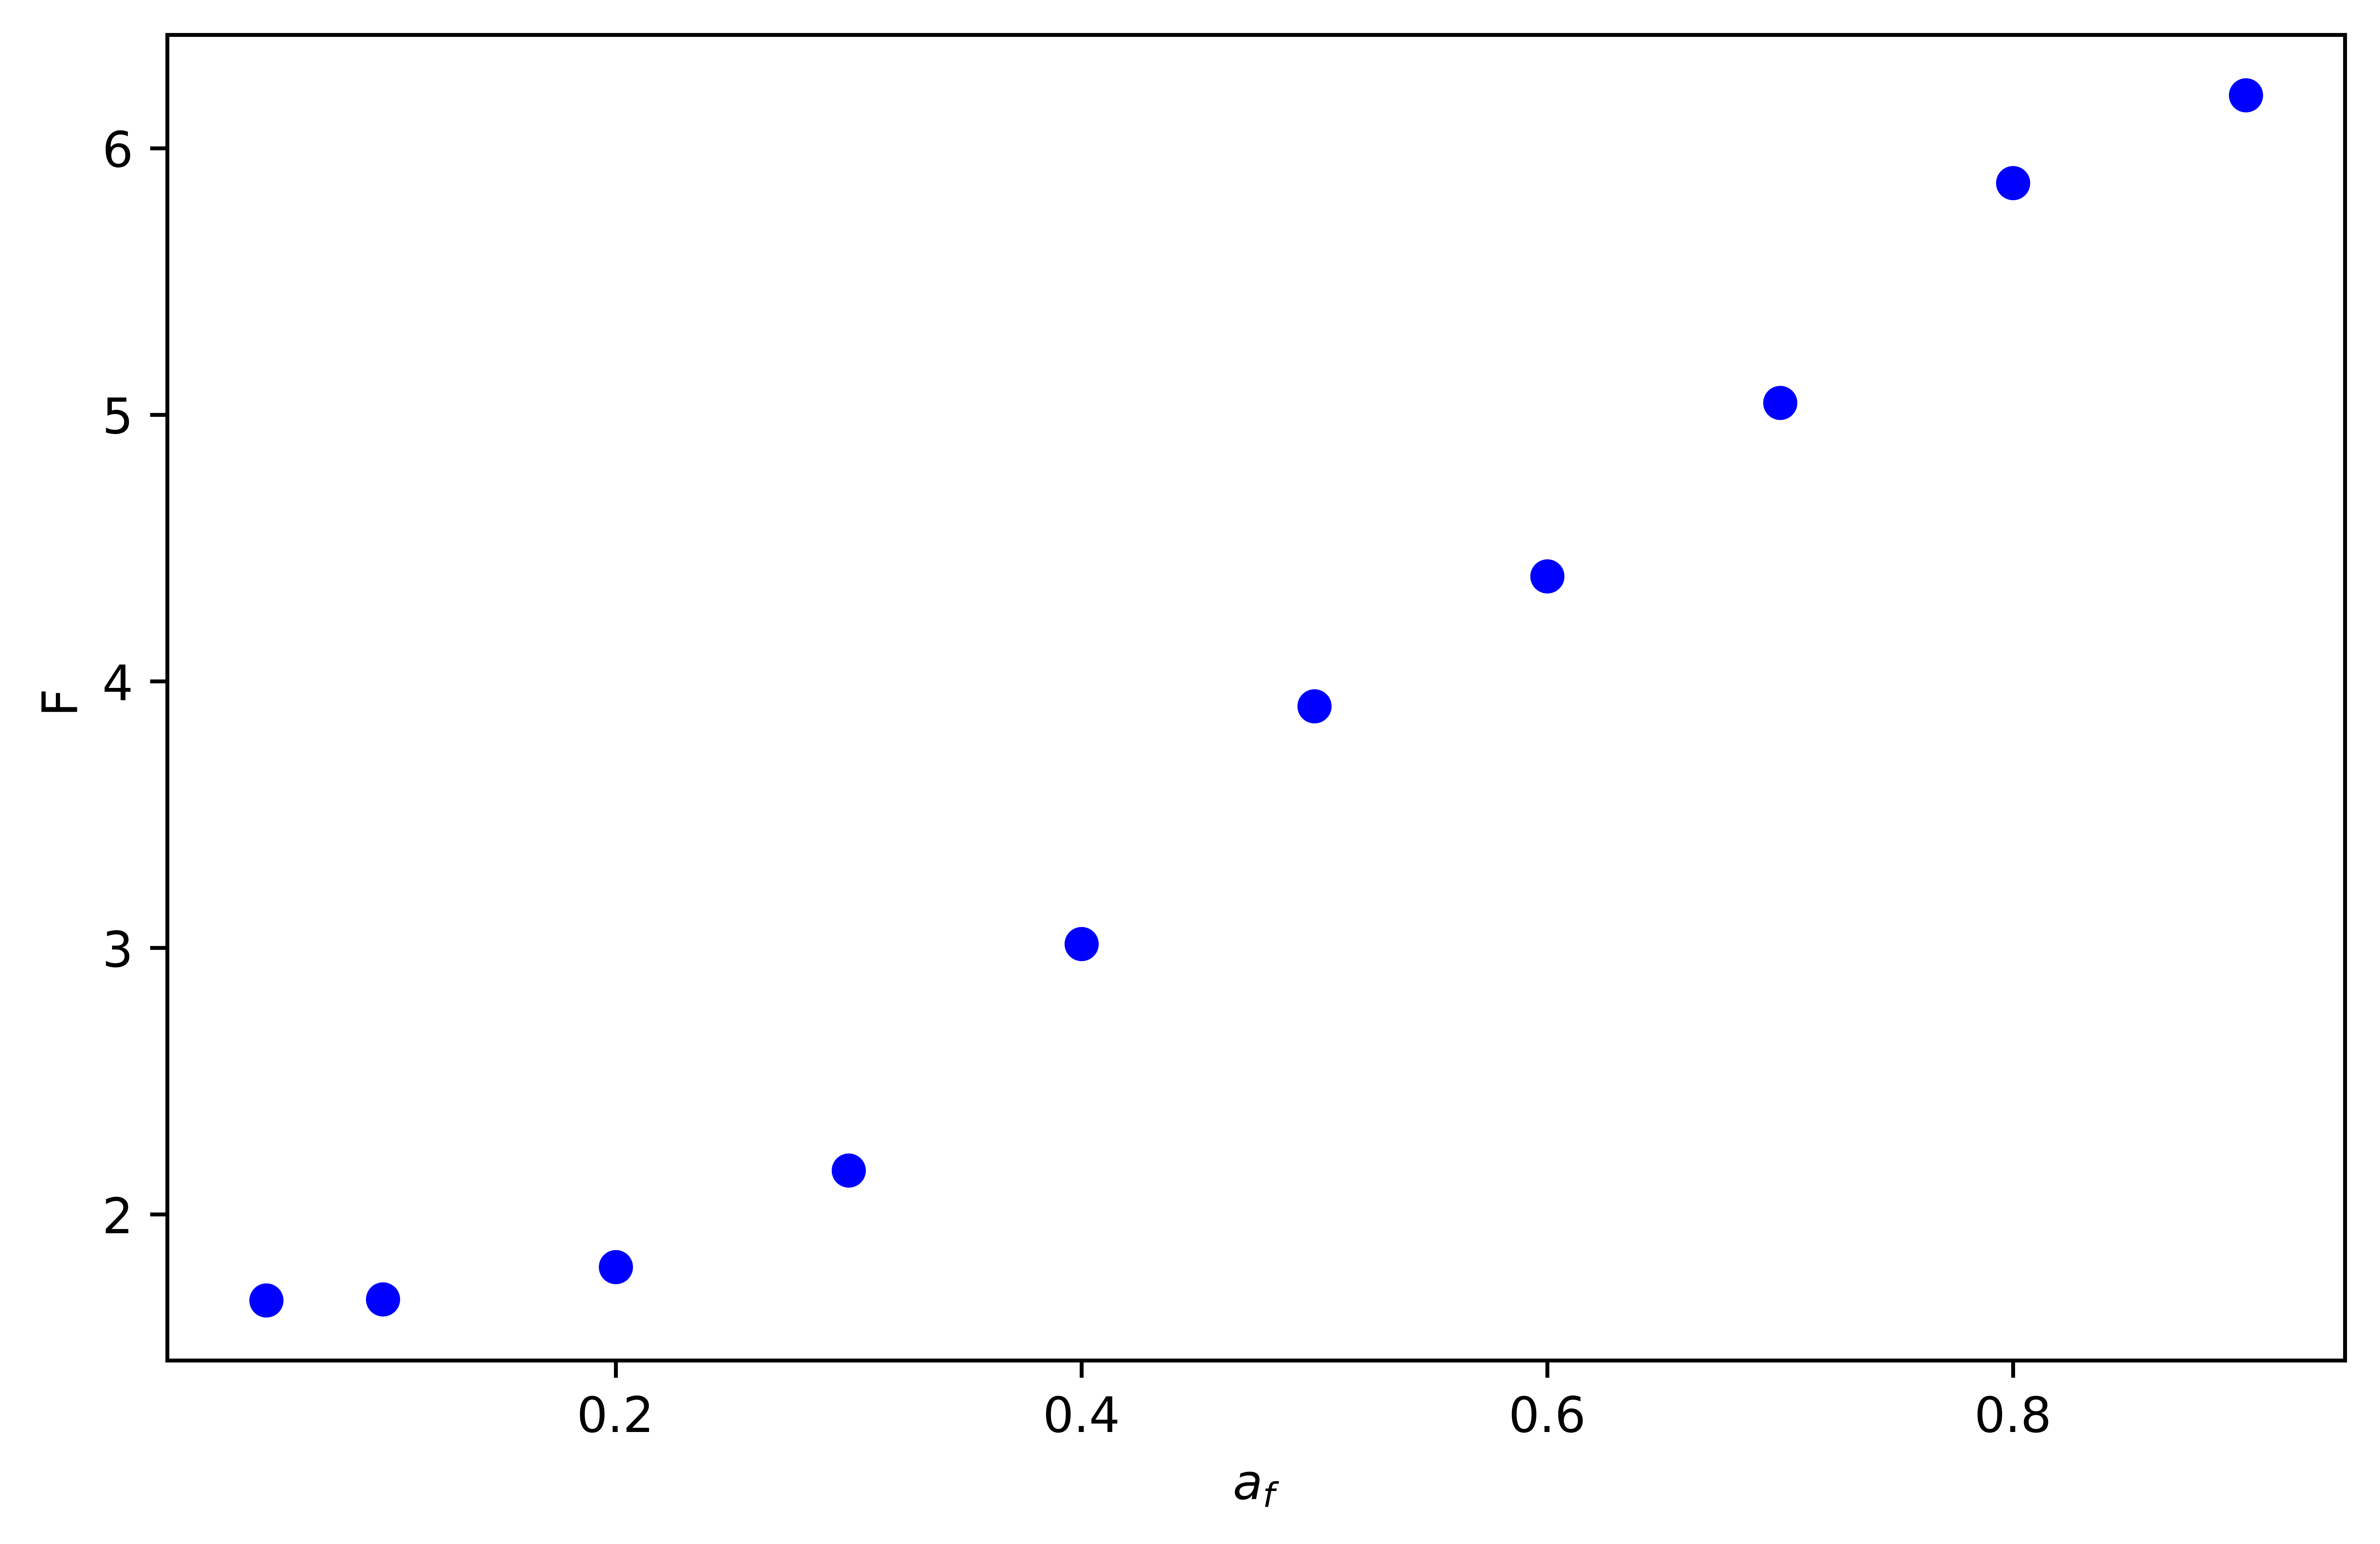

In [73]:
ig = plt.figure(figsize=(8,5), dpi=1000)
a_array=[0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
f_array=[f0_05,f0_1,f0_2,f0_3,f0_4,f0_5,f0_6,f0_7,f0_8,f0_9]
plt.plot(a_array,f_array,'bo')
plt.xlabel('$a_f$')
plt.ylabel('F')

In [71]:
f0_1

1.681119916848574

# **Entropy and Complexity**

In [1]:
def entropy1(labels, base=None):
    value,counts = np.unique(labels, return_counts=True)
    return entropy(counts, base=base)

def C(s):
    return s*(1-s)

In [2]:
valuesi=[]
for i in d1[1,:,:]:
    valuesi.append(i/np.max(deltai[1,:,:]))
    
valuesf=[]
for i in sim[1,:,:]:
    valuesf.append(i/np.max(sim[1,:,:]))
    
si=entropy1(valuesi)
ci=C(si)
print('S_i=',si,'C_i=',ci)

sf=entropy1(valuesf)
cf=C(sf)
print('Sf=',sf,'Cf=',cf)

NameError: ignored